In [2]:
#from statsmodels.tsa.arima_process import ArmaProcess 
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests

import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp


from sklearn.cluster import AgglomerativeClustering, DBSCAN

from statsmodels.tsa.stattools import adfuller
from Data import Data
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

from matplotlib import animation

import scipy.stats as st

import reverse_geocoder as rg

from pandas_datareader import wb
import scipy.stats as st

import Rung as rung

plt.rcParams["figure.figsize"] = (5,5)

from pandas_datareader import wb

import seaborn as sns

from sklearn import preprocessing

import seaborn as sns
import feature_finder_station as ff
import feature_finder_f as ff1
from statsmodels.tsa.stattools import adfuller

plt.rcParams["figure.figsize"] = (20,10)

In [3]:
train_start = 1971
validation_end = 2005

In [4]:
tau = 6
n_components_sst = 98

In [5]:
temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(validation_end, 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries("./npy_files/ET_gamma_18912015.npy",train_start,validation_end)
data_sst, ts, V, df_sst, avg, std = ff.PCA_computer_rotated('../../../nc/sst.mnmean.nc', "sst",temporal_limits, n_components_sst, -9.96921e+36)
#link = np.load("./link/link_{}_{}_{}.npy".format(train_start,validation_end,np.abs(tau)))
#link_corr = np.load("./link/link_corr_{}_{}_{}.npy".format(train_start,validation_end,np.abs(tau)))

In [78]:
#link = np.load("./link/link_{}_{}_{}.npy".format(train_start,validation_end,np.abs(tau)))
link = np.load("./links_rotated_detrend/link_{}_{}_{}.npy".format(train_start,validation_end,np.abs(tau)))
#link_differenced = np.load("./link_differenced/link_{}_{}_{}.npy".format(train_start,validation_end,np.abs(tau)))

In [116]:
original_count

AttributeError: 'list' object has no attribute 'shape'

In [102]:
def time_series_maker_V(data, V_value):
    return(np.ravel(np.matmul(data,V_value)))

def time_series_maker(pc, df_sst, result, level = 95): 
    if np.abs(df_sst.pc.values.min()) > np.abs(df_sst.pc.values.max()):
        limit = np.percentile(df_sst.pc.values, 1 - level)
        df_sst.pc.values[df_sst.pc.values>=limit]=np.nan
    else:
        limit = np.percentile(df_sst.pc.values, level)
        df_sst.pc.values[df_sst.pc.values<=limit]=np.nan

    I = np.where(~np.isnan(df_sst.pc.values))[0]

    d = result[:,I].mean(axis=1)
    d = np.ravel(d)
    return(d)

In [103]:
def crosscorr(datax, datay, lag=1):   
    return(stats.pearsonr(datax[lag:], datay[:-lag]))
        
def corr_generator(ts, count, tau_min = 1, tau_max = 12, level = 0.05):
    result_extremes = np.array(count)
    result_extremes = result_extremes.reshape((-1,1))

    result_sst = np.array(ts)

    data = np.concatenate((result_extremes,result_sst), axis=1)
    data = np.array(data)

    N = data.shape[1]-1
    result = np.zeros((tau_max - tau_min + 1,N))

    for j in range(1,N):
        for i in range(tau_min,tau_max + 1):
            r, pvalue = crosscorr(data[:,0],data[:,j],lag=i)
            result[i-tau_min,j] = r if pvalue < level else 0
      
    result = np.abs(result)
    #limit = np.percentile(result, percentile)
    limit = 0
    Index = np.where(result > limit)
    link = np.array(list(zip((Index[1]+1),(Index[0] + tau_min)*(-1)))) 
    result = result[Index]
    return(link[(-result).argsort()])

In [9]:
def data_list_maker_V(data_sst, V, link):
    df = pd.DataFrame()
    for k in range(len(link)):
        df[str(k)] = time_series_maker_V(data_sst, V[:,link[k,0]-1])
        df[str(k)] = df[str(k)].shift(abs(link[k,1]))
    df = df.dropna()
    return(df)

In [10]:
def data_list_maker(data_sst, df_sst, V, link):
    df = pd.DataFrame()
    for k in range(len(link)):
        df_sst["pc"] = V[:,link[k,0]-1]
        df[str(k)] = time_series_maker(link[k,0]-1, df_sst, data_sst)
        df[str(k)] = df[str(k)].shift(abs(link[k,1]))
    df = df.dropna()
    return(df)

In [119]:
def crosscorr(datax, datay, lag=1):   
    return(stats.pearsonr(datax[lag:], datay[:-lag]))
        
def corr_generator(ts, count, V, tau_min = 1, tau_max = 12, level = 0.05):
    result_extremes = np.array(count)
    result_extremes = result_extremes.reshape((-1,1))

    result_sst = np.array(ts)

    data = np.concatenate((result_extremes,result_sst), axis=1)
    data = np.array(data)

    N = data.shape[1]-1
    result = np.zeros((tau_max - tau_min + 1,N))

    for j in range(1,N):
        for i in range(tau_min,tau_max + 1):
            r, pvalue = crosscorr(data[:,0],data[:,j],lag=i)
            result[i-tau_min,j] = r if pvalue < level else 0
      
    result = np.abs(result)
    #limit = np.percentile(result, percentile)
    limit = 0
    Index = np.where(result > limit)
    link = np.array(list(zip((Index[1]+1),(Index[0] + tau_min)*(-1)))) 
    result = result[Index]
    link = link[(-result).argsort()]
    
    df = data_list_maker_V(result_sst, V, link)
    deleted_index = []
    componenets = set(link[:,0])
    for componenet in componenets:
        componenet_index = (link[:,0] == componenet)
        componenet_list = link[componenet_index]
        Index = componenet_index.nonzero()[0]
        sorted_index = np.argsort(componenet_list[:,1],axis=0)
        mx = ma.masked_array(componenet_list)
        for i in range(len(sorted_index)):
            if ma.is_masked(mx[sorted_index[i]]): continue
            for j in range(i+1,len(sorted_index)):
                if (not ma.is_masked(mx[sorted_index[i]]) and (df.iloc[:,Index[sorted_index[i]]].corr(df.iloc[:,Index[sorted_index[j]]]) > 0.8)):
                    mx[sorted_index[j]] = ma.masked

        if not np.isscalar(mx.mask):
            deleted_index.extend(Index[mx.mask[:,0].nonzero()[0]])
    deleted_index = np.array(deleted_index)
    link = np.delete(link,deleted_index,axis=0)    
    
    return(link)

In [112]:
tau_min = tau
tau_max = tau+12

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((-1,1))

result_sst = np.array(ts)

data = np.concatenate((result_extremes,result_sst), axis=1)
data = np.array(data)

N = data.shape[1]-1
result = np.zeros((tau_max - tau_min + 1,N))

for j in range(1,N):
    for i in range(tau_min,tau_max + 1):
        r, pvalue = crosscorr(data[:,0],data[:,j],lag=i)
        result[i-tau_min,j] = r if pvalue < level else 0

result = np.abs(result)
#limit = np.percentile(result, percentile)
limit = 0
Index = np.where(result > limit)
link = np.array(list(zip((Index[1]+1),(Index[0] + tau_min)*(-1)))) 
result = result[Index]
link = link[(-result).argsort()]

In [124]:
V.shape

(10988, 98)

In [121]:
def data_list_maker_V(data_sst, V, link):
    df = pd.DataFrame()
    for k in range(len(link)):
        df[str(k)] = time_series_maker_V(data_sst, V[:,link[k,0]-1])
        df[str(k)] = df[str(k)].shift(abs(link[k,1]))
    df = df.dropna()
    return(df)

def data_list_maker(data_sst, df_sst, V, link):
    df = pd.DataFrame()
    for k in range(len(link)):
        df_sst["pc"] = V[:,link[k,0]-1]
        df[str(k)] = time_series_maker(link[k,0]-1, df_sst, data_sst)
        df[str(k)] = df[str(k)].shift(abs(link[k,1]))
    df = df.dropna()
    return(df)

In [6]:
ff.corr_generator(ts, count, V,data_sst, tau_min = tau, tau_max = tau+12)

array([[ 26,  -9],
       [ 26, -11],
       [ 27, -15],
       [ 25, -10],
       [ 50,  -6],
       [ 50,  -8],
       [ 50,  -7],
       [ 27, -14],
       [ 66, -18],
       [ 25, -12],
       [ 26,  -7],
       [ 25, -14],
       [ 50,  -9],
       [ 27, -16],
       [ 66, -17],
       [ 82, -11],
       [ 82, -12],
       [ 66, -16],
       [ 50, -10],
       [ 50, -11],
       [ 63, -12],
       [ 63, -13],
       [ 62, -12],
       [ 26, -13],
       [ 82, -10],
       [ 25, -16],
       [ 62, -14],
       [ 50, -13],
       [ 27, -17],
       [ 50, -12],
       [ 20,  -6],
       [ 66, -15],
       [ 27, -13],
       [ 62,  -6],
       [ 66, -13],
       [ 25,  -8],
       [ 82, -13],
       [ 66, -14],
       [ 63, -11],
       [ 63,  -6],
       [  4,  -7],
       [ 50, -14],
       [ 62,  -8],
       [ 89,  -9],
       [ 27, -18],
       [ 89, -10],
       [ 89,  -8],
       [ 66, -12],
       [ 45, -14],
       [ 63, -14],
       [ 63, -10],
       [ 45, -12],
       [ 89,

In [270]:
df = data_list_maker_V(data_sst, V, link)

In [268]:
len(link)

348

In [128]:
def crosscorr(datax, datay, lag=1):   
    return(stats.pearsonr(datax[lag:], datay[:-lag]))
        
def corr_generator(ts, count, V, data_sst, tau_min = 1, tau_max = 12, level = 0.05):
    result_extremes = np.array(count)
    result_extremes = result_extremes.reshape((-1,1))

    result_sst = np.array(ts)

    data = np.concatenate((result_extremes,result_sst), axis=1)
    data = np.array(data)

    N = data.shape[1]-1
    result = np.zeros((tau_max - tau_min + 1,N))

    for j in range(1,N):
        for i in range(tau_min,tau_max + 1):
            r, pvalue = crosscorr(data[:,0],data[:,j],lag=i)
            result[i-tau_min,j] = r if pvalue < level else 0
      
    result = np.abs(result)
    #limit = np.percentile(result, percentile)
    limit = 0
    Index = np.where(result > limit)
    link = np.array(list(zip((Index[1]+1),(Index[0] + tau_min)*(-1)))) 
    result = result[Index]
    link = link[(-result).argsort()]
    
    df = data_list_maker_V(data_sst, V, link)
    deleted_index = []
    componenets = set(link[:,0])
    for componenet in componenets:
        componenet_index = (link[:,0] == componenet)
        componenet_list = link[componenet_index]
        Index = componenet_index.nonzero()[0]
        sorted_index = np.argsort(componenet_list[:,1],axis=0)
        mx = ma.masked_array(componenet_list)
        for i in range(len(sorted_index)):
            if ma.is_masked(mx[sorted_index[i]]): continue
            for j in range(i+1,len(sorted_index)):
                if (not ma.is_masked(mx[sorted_index[i]]) and (df.iloc[:,Index[sorted_index[i]]].corr(df.iloc[:,Index[sorted_index[j]]]) > 0.8)):
                    mx[sorted_index[j]] = ma.masked

        if not np.isscalar(mx.mask):
            deleted_index.extend(Index[mx.mask[:,0].nonzero()[0]])
    deleted_index = np.array(deleted_index)
    link = np.delete(link,deleted_index,axis=0)    
    
    return(link)

In [131]:
corr_generator(ts, count, V, data_sst, tau_min = tau, tau_max = tau+12, level = 0.05)

NameError: name 'ma' is not defined

In [272]:
deleted_index = []
componenets = set(link[:,0])
for componenet in componenets:
    componenet_index = (link[:,0] == componenet)
    componenet_list = link[componenet_index]
    Index = componenet_index.nonzero()[0]
    sorted_index = np.argsort(componenet_list[:,1],axis=0)
    mx = ma.masked_array(componenet_list)
    for i in range(len(sorted_index)):
        if ma.is_masked(mx[sorted_index[i]]): continue
        for j in range(i+1,len(sorted_index)):
            if (not ma.is_masked(mx[sorted_index[i]]) and (df.iloc[:,Index[sorted_index[i]]].corr(df.iloc[:,Index[sorted_index[j]]]) > 0.8)):
                mx[sorted_index[j]] = ma.masked

    if not np.isscalar(mx.mask):
        deleted_index.extend(Index[mx.mask[:,0].nonzero()[0]])
deleted_index = np.array(deleted_index)
link = np.delete(link,deleted_index,axis=0)
df = df.drop(deleted_index.astype(str),1)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


In [273]:
len(np.array(deleted_index))

0

In [257]:
df

,0,3,4,5,7,8,9,10,11,12,...,393,394,395,396,397,398,399,400,401,402
18,0.115737,7.404402,4.988298,-3.375340,-10.516965,-20.599085,0.985219,-8.710319,3.477051,-7.431535,...,-10.580576,19.538051,11.230600,4.607797,-15.996106,10.111481,2.260779,-11.730663,0.416422,1.856263
19,-2.482172,4.988298,2.939687,-4.887017,7.404402,-6.453736,3.186111,-7.431535,-0.826929,1.835314,...,-2.722518,5.627400,8.756176,3.931343,-9.745866,9.697466,0.475911,-6.384196,1.239744,-0.059317
20,3.477051,2.939687,2.721528,0.115737,4.988298,-3.375340,7.990915,1.835314,-1.079726,0.490435,...,-1.486615,-1.175475,5.375925,7.365261,-13.098978,9.300309,-9.743694,-6.148592,-6.257140,-3.205030
21,-0.826929,2.721528,-0.408153,-2.482172,2.939687,-4.887017,-4.781666,0.490435,-2.058440,-0.994797,...,-0.188573,7.172726,5.254627,9.198228,-7.632522,6.464252,-5.278854,-5.088164,-6.605494,0.544087
22,-1.079726,-0.408153,-0.122292,3.477051,2.721528,0.115737,-5.990024,-0.994797,-9.033158,-4.978797,...,1.730430,20.260135,7.432529,9.299135,-6.682869,9.159834,-2.927974,2.960728,-13.385778,0.878666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,18.680493,-14.662967,-14.115284,27.415610,-12.264561,19.757490,1.723742,7.405580,17.209959,7.999048,...,-0.640148,3.225719,3.520834,4.230573,-4.672241,3.569055,-2.183739,-3.517970,0.399085,4.356690
416,13.448757,-14.115284,-7.177694,26.495057,-14.662967,24.945452,2.663283,7.999048,9.900184,12.216653,...,4.046731,1.434156,5.009680,10.424277,3.354322,6.544104,5.222600,-9.383889,-3.088490,1.346368
417,17.209959,-7.177694,-7.897479,18.680493,-14.115284,27.415610,5.715615,12.216653,5.744294,9.257192,...,1.401859,0.890576,0.134005,6.657883,7.964263,-2.136136,2.774503,-20.798235,-4.351696,-2.030791
418,9.900184,-7.897479,-10.670743,13.448757,-7.177694,26.495057,5.194954,9.257192,-3.074319,15.146518,...,2.547324,1.988338,5.558245,6.028436,7.232119,-3.335470,-6.777768,-17.725361,-1.049728,-8.087886


In [209]:
componenet_index = (link[:,0] == 42)
componenet_list = link[componenet_index]
Index = componenet_index.nonzero()[0]
sorted_index = np.argsort(componenet_list[:,1],axis=0)

In [210]:
mx = ma.masked_array(componenet_list)
for i in range(len(sorted_index)):
    if ma.is_masked(mx[sorted_index[i]]): continue
    for j in range(i+1,len(sorted_index)):
        if (not ma.is_masked(mx[sorted_index[i]]) and (df.iloc[:,Index[sorted_index[i]]].corr(df.iloc[:,Index[sorted_index[j]]]) > 0.8)):
            mx[sorted_index[j]] = ma.masked
            
deleted_index = Index[mx.mask[:,0].nonzero()[0]]
link = np.delete(link,Index[mx.mask[:,0].nonzero()[0]],axis=0)
df = df.drop(deleted_index.astype(str),1)

In [155]:
componenet_index.nonzero()[0]

array([ 0,  1,  2,  5,  6,  8, 11, 14, 30, 32, 38, 48, 58])

In [147]:
mx.mask[:,0].nonzero()[0]

array([ 1,  2,  4,  7,  8, 10])

In [148]:
Index[mx.mask[:,0].nonzero()[0]]

array([ 1,  2,  6, 14, 30, 38])

In [171]:
deleted_index = Index[mx.mask[:,0].nonzero()[0]]

In [174]:
deleted_index.astype(str)

array(['1', '2', '6', '14', '30', '38'], dtype='<U21')

In [156]:
link[Index[mx.mask[:,0].nonzero()[0]]]

array([[ 25,  -9],
       [ 25, -11],
       [ 25, -13],
       [ 25, -15],
       [ 25,  -7],
       [ 25, -17]])

In [176]:
#link

In [175]:
link = np.delete(link,Index[mx.mask[:,0].nonzero()[0]],axis=0)
df = df.drop(deleted_index.astype(str),1)

,0,3,4,5,7,8,9,10,11,12,...,393,394,395,396,397,398,399,400,401,402
18,0.115737,7.404402,4.988298,-3.375340,-10.516965,-20.599085,0.985219,-8.710319,3.477051,-7.431535,...,-10.580576,19.538051,11.230600,4.607797,-15.996106,10.111481,2.260779,-11.730663,0.416422,1.856263
19,-2.482172,4.988298,2.939687,-4.887017,7.404402,-6.453736,3.186111,-7.431535,-0.826929,1.835314,...,-2.722518,5.627400,8.756176,3.931343,-9.745866,9.697466,0.475911,-6.384196,1.239744,-0.059317
20,3.477051,2.939687,2.721528,0.115737,4.988298,-3.375340,7.990915,1.835314,-1.079726,0.490435,...,-1.486615,-1.175475,5.375925,7.365261,-13.098978,9.300309,-9.743694,-6.148592,-6.257140,-3.205030
21,-0.826929,2.721528,-0.408153,-2.482172,2.939687,-4.887017,-4.781666,0.490435,-2.058440,-0.994797,...,-0.188573,7.172726,5.254627,9.198228,-7.632522,6.464252,-5.278854,-5.088164,-6.605494,0.544087
22,-1.079726,-0.408153,-0.122292,3.477051,2.721528,0.115737,-5.990024,-0.994797,-9.033158,-4.978797,...,1.730430,20.260135,7.432529,9.299135,-6.682869,9.159834,-2.927974,2.960728,-13.385778,0.878666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,18.680493,-14.662967,-14.115284,27.415610,-12.264561,19.757490,1.723742,7.405580,17.209959,7.999048,...,-0.640148,3.225719,3.520834,4.230573,-4.672241,3.569055,-2.183739,-3.517970,0.399085,4.356690
416,13.448757,-14.115284,-7.177694,26.495057,-14.662967,24.945452,2.663283,7.999048,9.900184,12.216653,...,4.046731,1.434156,5.009680,10.424277,3.354322,6.544104,5.222600,-9.383889,-3.088490,1.346368
417,17.209959,-7.177694,-7.897479,18.680493,-14.115284,27.415610,5.715615,12.216653,5.744294,9.257192,...,1.401859,0.890576,0.134005,6.657883,7.964263,-2.136136,2.774503,-20.798235,-4.351696,-2.030791
418,9.900184,-7.897479,-10.670743,13.448757,-7.177694,26.495057,5.194954,9.257192,-3.074319,15.146518,...,2.547324,1.988338,5.558245,6.028436,7.232119,-3.335470,-6.777768,-17.725361,-1.049728,-8.087886


In [123]:
sorted_index

array([12, 10,  9,  7,  5,  4,  3,  2,  0,  1,  6,  8, 11])

In [126]:
mx

masked_array(
  data=[[25, -10],
        [--, --],
        [--, --],
        [25, -12],
        [--, --],
        [25, -14],
        [25, -8],
        [--, --],
        [--, --],
        [25, -16],
        [--, --],
        [25, -6],
        [25, -18]],
  mask=[[False, False],
        [ True,  True],
        [ True,  True],
        [False, False],
        [ True,  True],
        [False, False],
        [False, False],
        [ True,  True],
        [ True,  True],
        [False, False],
        [ True,  True],
        [False, False],
        [False, False]],
  fill_value=999999)

In [107]:
i = link[:,0] == 25

In [58]:
l = link[i]

In [59]:
l

array([[ 25, -10],
       [ 25,  -9],
       [ 25, -11],
       [ 25, -12],
       [ 25, -13],
       [ 25, -14],
       [ 25,  -8],
       [ 25, -15],
       [ 25,  -7],
       [ 25, -16],
       [ 25, -17],
       [ 25,  -6],
       [ 25, -18]])

In [51]:
#sorted(l, key=lambda x : x[1])

In [60]:
I = np.argsort(l[:,1],axis=0)

In [61]:
I

array([12, 10,  9,  7,  5,  4,  3,  2,  0,  1,  6,  8, 11])

In [68]:
deleted = []

In [67]:
if df.iloc[:,Index[I[0]]].corr(df.iloc[:,Index[I[1]]]) > 0.8 and :
    

True

In [69]:
import numpy.ma as ma

In [70]:
mx = ma.masked_array(l)

In [87]:
mx[3] = ma.masked

In [89]:
not ma.is_masked(mx[3])

False

In [97]:
mx.mask.nonzero()[0]

array([3, 3])

In [79]:
l[I]

array([[ 25, -18],
       [ 25, -17],
       [ 25, -16],
       [ 25, -15],
       [ 25, -14],
       [ 25, -13],
       [ 25, -12],
       [ 25, -11],
       [ 25, -10],
       [ 25,  -9],
       [ 25,  -8],
       [ 25,  -7],
       [ 25,  -6]])

In [63]:
Index = i.nonzero()[0]

In [122]:
Index

array([ 0,  1,  2,  5,  6,  8, 11, 14, 30, 32, 38, 48, 58])

In [23]:
df1 = df.iloc[:,i]

In [19]:
df = data_list_maker_V(data_sst, V, link)

In [24]:
corr = df1.corr()

In [26]:
corr

,0,1,2,5,6,8,11,14,30,32,38,48,58
0,1.000000,0.816728,0.817557,0.710984,0.587336,0.484913,0.708637,0.411720,0.581792,0.351297,0.311559,0.479481,0.264187
1,0.816728,1.000000,0.708830,0.582924,0.485190,0.408768,0.816471,0.344323,0.708915,0.305072,0.260094,0.581994,0.200698
2,0.817557,0.708830,1.000000,0.817574,0.712006,0.586128,0.582326,0.485146,0.481485,0.412652,0.352171,0.401879,0.311811
5,0.710984,0.582924,0.817574,1.000000,0.817370,0.708289,0.483450,0.583898,0.405303,0.483517,0.410179,0.338254,0.348409
6,0.587336,0.485190,0.712006,0.817370,1.000000,0.814401,0.409179,0.705384,0.344432,0.579182,0.477621,0.297193,0.403664
8,0.484913,0.408768,0.586128,0.708289,0.814401,1.000000,0.343175,0.814971,0.300339,0.702753,0.579133,0.244960,0.480573
11,0.708637,0.816471,0.582326,0.483450,0.409179,0.343175,1.000000,0.302384,0.816393,0.257551,0.199172,0.707870,0.152477
14,0.411720,0.344323,0.485146,0.583898,0.705384,0.814971,0.302384,1.000000,0.250837,0.812146,0.700553,0.184543,0.577425
30,0.581792,0.708915,0.481485,0.405303,0.344432,0.300339,0.816393,0.250837,1.000000,0.193709,0.149718,0.816810,0.118392
32,0.351297,0.305072,0.412652,0.483517,0.579182,0.702753,0.257551,0.812146,0.193709,1.000000,0.807460,0.140610,0.692485


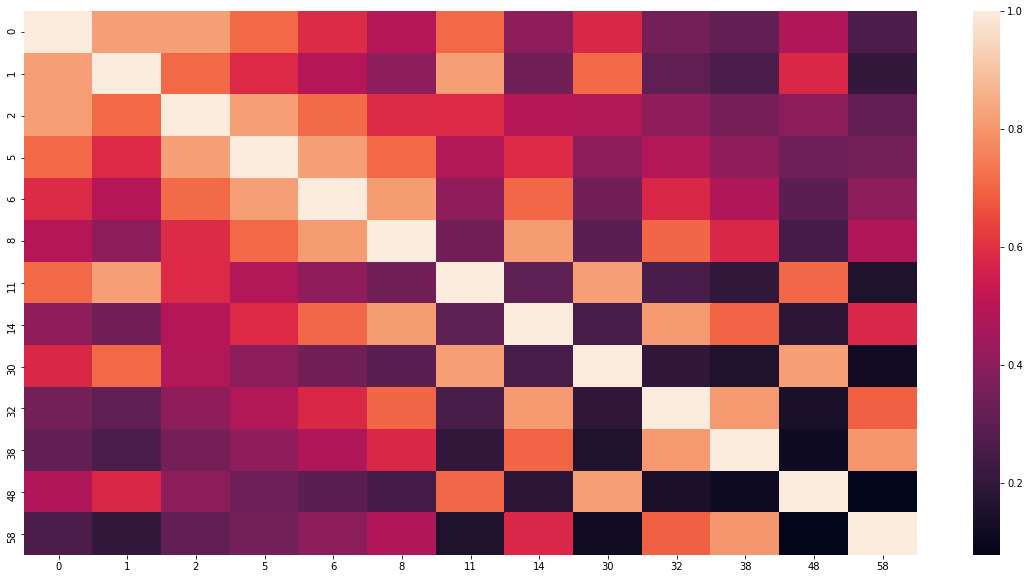

In [25]:
sns.heatmap(corr)

In [94]:
corr

,0,1,2,3,4,5,6,7,8,9,...,393,394,395,396,397,398,399,400,401,402
0,1.000000,0.816728,0.817557,-0.098829,-0.096253,0.710984,0.587336,-0.104769,0.484913,0.052629,...,0.033158,0.166162,0.058470,-0.084555,0.037965,-0.049590,-0.193557,-0.154481,0.067048,-0.014575
1,0.816728,1.000000,0.708830,-0.103616,-0.097096,0.582924,0.485190,-0.061747,0.408768,0.007305,...,-0.007384,0.171390,0.024342,-0.085196,-0.009269,-0.010973,-0.201013,-0.107455,0.062326,-0.021350
2,0.817557,0.708830,1.000000,-0.095395,-0.096802,0.817574,0.712006,-0.095107,0.586128,0.055646,...,0.090885,0.125842,0.087788,-0.093689,0.062780,-0.085364,-0.159093,-0.169232,0.082469,0.027783
3,-0.098829,-0.103616,-0.095395,1.000000,0.725881,-0.093953,-0.103352,0.720341,-0.091385,0.152356,...,-0.052132,-0.075061,-0.100021,-0.030663,0.148487,-0.076175,-0.022998,0.053534,0.039278,0.158249
4,-0.096253,-0.097096,-0.096802,0.725881,1.000000,-0.108298,-0.092403,0.492871,-0.096694,0.154050,...,-0.038783,-0.052845,-0.057351,-0.061317,0.167413,-0.079469,-0.009351,0.036629,0.068832,0.122356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,-0.049590,-0.010973,-0.085364,-0.076175,-0.079469,-0.108760,-0.129144,-0.053773,-0.154455,-0.128214,...,-0.158915,0.161698,-0.242696,0.005603,-0.207316,1.000000,-0.100810,0.139051,-0.066069,0.057816
399,-0.193557,-0.201013,-0.159093,-0.022998,-0.009351,-0.133952,-0.130392,-0.017630,-0.124982,0.077791,...,0.083552,-0.077706,0.084762,0.128278,-0.057215,-0.100810,1.000000,-0.098260,-0.024621,0.104646
400,-0.154481,-0.107455,-0.169232,0.053534,0.036629,-0.179577,-0.218258,0.069631,-0.247940,0.015918,...,-0.092745,0.161675,-0.090102,0.055214,0.018673,0.139051,-0.098260,1.000000,-0.111887,-0.014020
401,0.067048,0.062326,0.082469,0.039278,0.068832,0.081672,0.081373,0.045525,0.073849,0.125146,...,0.005136,-0.058945,0.004922,-0.086001,0.096492,-0.066069,-0.024621,-0.111887,1.000000,-0.035636


In [168]:
def shift_df(df, start_lag = 1, end_lag = 12):
    lags = np.arange(start_lag,end_lag + 1)
    df = df.assign(**{
    '{} (t-{})'.format(col, t): df[col].shift(t)
    for t in lags
    for col in df
    })
    df = df.dropna()
    return(df)

In [169]:
df = pd.DataFrame({"drought":original_count})

In [170]:
df = shift_df(df, 12, 24)

In [171]:
ratio=0.8
n_estimators=100
max_depth=5
index = int(df.shape[0]*ratio)
dim = df.shape[1]

x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim]
y_train, y_test = df.iloc[:index,0], df.iloc[index:,0]

In [172]:
x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim]
y_train, y_test = df.iloc[:index,0], df.iloc[index:,0]
model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [173]:
mean_squared_error(y_pred, y_test)

1230.893941641188

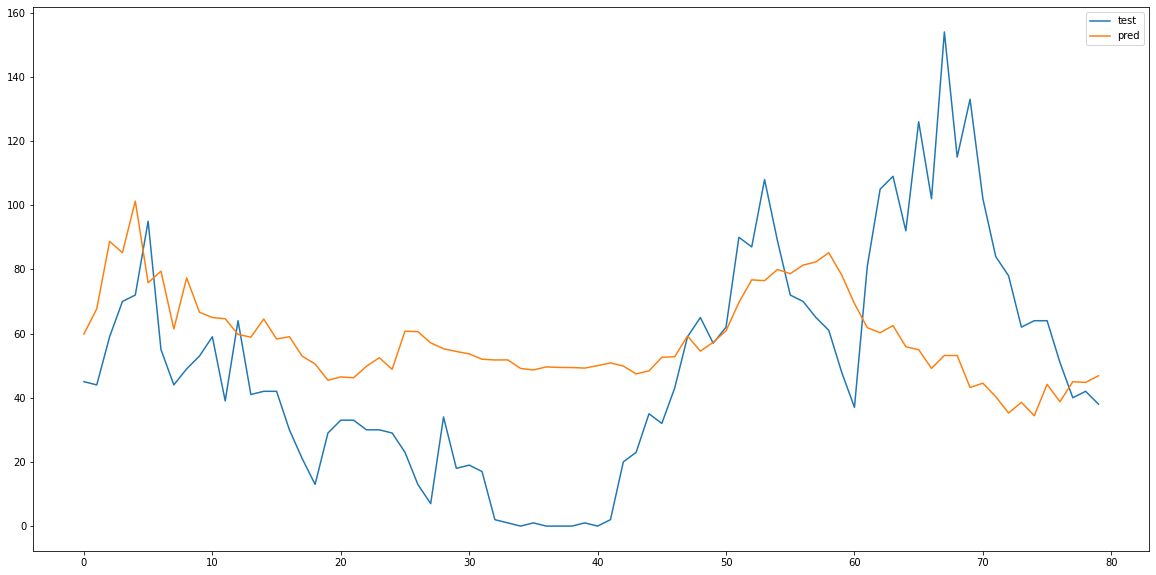

In [174]:
x = np.arange(len(y_test))
plt.plot(x,y_test, label = 'test')
plt.plot(x,y_pred, label = 'pred')
plt.legend()

In [146]:
start_lag = 12
end_lag = 24

In [147]:
df = pd.DataFrame({"drought":original_count})
lags = np.arange(start_lag,end_lag + 1)
df = df.assign(**{
'{} (t-{})'.format(col, t): df[col].shift(t)
for t in lags
for col in df
})

In [132]:
link_result = np.array(link_result)

In [148]:
for k in range(1):
        df_sst["pc"] = V[:,link[k,0]-1]
        df[str(k)] = time_series_maker_V(data_sst, V[:,link[k,0]-1])
        df[str(k)] = df[str(k)].shift(abs(link[k,1]))
df = df.dropna()

In [149]:
index = int(df.shape[0]*ratio)

In [352]:
df = base

In [353]:
x_train, x_test = df.iloc[:index,1:], df.iloc[index:,1:]
y_train, y_test = df.iloc[:index,0], df.iloc[index:,0]

In [354]:
model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_pred, y_test)

In [370]:
((y_test - y_pred)/y_test).values

array([ 4.75950212e-02, -1.48166907e-01,  2.04574455e-02,  2.20249344e-01,
        3.69244324e-01,  4.15395826e-01,  4.39906369e-01,  4.74855478e-02,
       -1.41383120e-01, -3.64513326e-01, -4.10404480e-01, -3.16335597e-01,
       -9.55122146e-01,  2.21522705e-01, -1.09775896e-01, -2.76221082e-02,
       -6.52793748e-02, -9.03228678e-01, -9.70016137e-01, -3.47716304e+00,
       -5.58988391e-01, -2.76303251e-01, -2.85526974e-01, -1.32211212e-01,
       -2.67817506e-01,  1.77546522e-01, -3.19511113e-01, -1.43932109e+00,
       -4.25590270e+00, -2.14888111e-01, -1.49386305e+00, -1.46831196e+00,
       -1.43886626e+00, -1.54800183e+01, -2.02053607e+01,            -inf,
       -3.64191961e+01,            -inf,            -inf,            -inf,
       -3.02505733e+01,            -inf, -1.10157262e+01, -2.83396221e-01,
       -1.59493775e-01, -1.76481509e-02, -6.05907553e-01,  2.13540103e-02,
        2.84812337e-01,  3.87505453e-02, -2.10612967e-01, -1.21616176e-01,
        2.14330403e-01,  

In [363]:
y_test.values

array([ 47,  45,  44,  59,  70,  72,  95,  55,  44,  49,  53,  59,  39,
        64,  41,  42,  42,  30,  21,  13,  29,  33,  33,  30,  30,  29,
        23,  13,   7,  34,  18,  19,  17,   2,   1,   0,   1,   0,   0,
         0,   1,   0,   2,  20,  23,  35,  32,  43,  59,  65,  57,  62,
        90,  87, 108,  89,  72,  70,  65,  61,  48,  37,  81, 105, 109,
        92, 126, 102, 154, 115, 133, 102,  84,  78,  62,  64,  64,  51,
        40,  42,  38])

In [355]:
mse

578.6109047892405

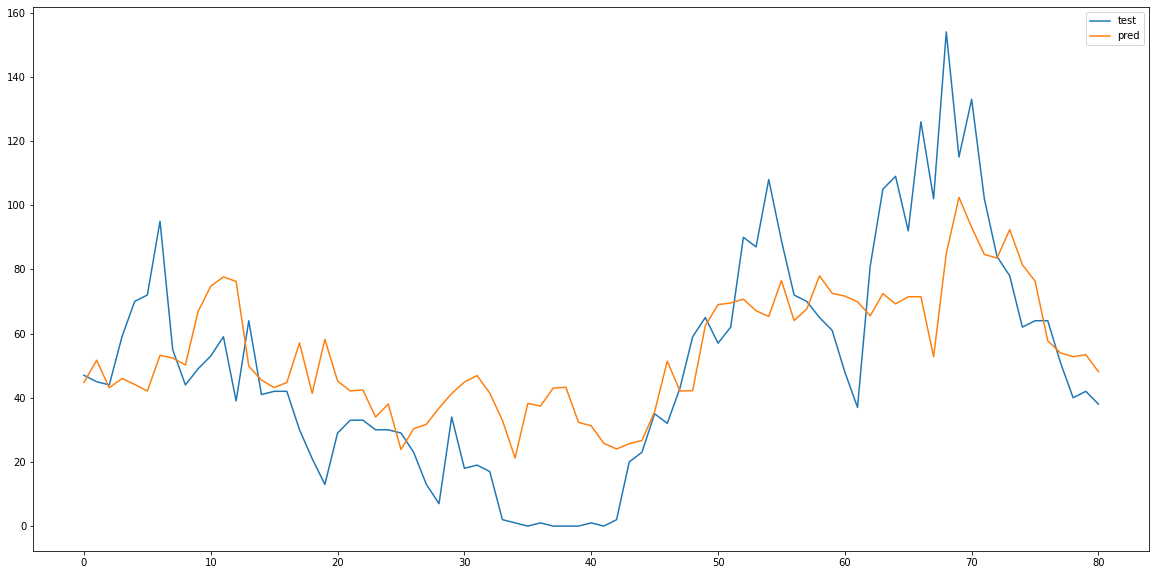

In [356]:
x = np.arange(len(y_test))
plt.plot(x,y_test, label = 'test')
plt.plot(x,y_pred, label = 'pred')
plt.legend()

In [ ]:
for z in range(len(link)):
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    for k in range(0,z+1):
            df_sst["pc"] = V[:,link[k,0]-1]
            df[str(k)] = time_series_maker_V(data_sst, V[:,link[k,0]-1])
            df[str(k)] = df[str(k)].shift(abs(link[k,1]))
    df = df.dropna()
    index = int(df.shape[0]*ratio)
    #dim = df.shape[1]
    #index +=tau

    x_train, x_test = df.iloc[:index,1:], df.iloc[index:,1:]
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0]
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_pred, y_test)
    if mse < result[-1]:
        result.append(mean_squared_error(y_pred, y_test))
        link_result.append(link[z])

In [25]:
ratio=0.8
n_estimators=100
max_depth=5

In [26]:
result = []
link_result = []

In [14]:
def time_series_maker_V(data, V_value):
    return(np.ravel(np.matmul(data,V_value)))

In [15]:
def time_series_maker(pc, df_sst, result, level = 95): 
    if np.abs(df_sst.pc.values.min()) > np.abs(df_sst.pc.values.max()):
        limit = np.percentile(df_sst.pc.values, 1 - level)
        df_sst.pc.values[df_sst.pc.values>=limit]=np.nan
    else:
        limit = np.percentile(df_sst.pc.values, level)
        df_sst.pc.values[df_sst.pc.values<=limit]=np.nan

    I = np.where(~np.isnan(df_sst.pc.values))[0]

    d = result[:,I].mean(axis=1)
    d = np.ravel(d)
    return(d)

In [79]:
def feature_score(base, feature,ratio= 0.8, n_estimators=100, max_depth=5):
    df = pd.concat([base, feature],axis=1)
    index = int(df.shape[0]*ratio)

    x_train, x_test = df.iloc[:index,1:], df.iloc[index:,1:]
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0]
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return(mean_squared_error(y_pred, y_test))
    

In [80]:
def shift_df(df, start_lag = 1, end_lag = 12):
    lags = np.arange(start_lag,end_lag + 1)
    df = df.assign(**{
    '{} (t-{})'.format(col, t): df[col].shift(t)
    for t in lags
    for col in df
    })
    df = df.dropna()
    return(df)

In [81]:
def forward_feature_V(count, data_sst, link, V, tau,  ratio = 0.8, n_estimators=100, max_depth=5):
    result = []
    link_list = []
    start_lag = tau
    end_lag = tau + 12
    df = pd.DataFrame({"drought":count})
    
    df = shift_df(df, start_lag, end_lag)
    index = int(df.shape[0]*ratio)
    dim = df.shape[1]
    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim]
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0]
    base_model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    base_model.fit(x_train, y_train)
    y_pred = base_model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))
    
    df = pd.DataFrame({"drought":original_count})
    lags = np.arange(start_lag,end_lag + 1)
    df = df.assign(**{
    '{} (t-{})'.format(col, t): df[col].shift(t)
    for t in lags
    for col in df
    })
    for k in range(len(link)):
        df[str(k)] = time_series_maker_V(data_sst, V[:,link[k,0]-1])
        df[str(k)] = df[str(k)].shift(abs(link[k,1]))
    df = df.dropna()
    
    base = df.iloc[:,:14].copy()
    features = df.iloc[:,14:].copy()
    
    while features.shape[1]>0:
        min_mse = np.Inf
        min_index = 0
        for c in features.columns:
            mse = feature_score(base, features[c])
            if (result[-1] > mse) and (min_mse > mse):
                min_mse = mse
                min_index = c
        if isinstance(min_index, int): break
        result.append(min_mse)
        base = pd.concat([base, features[min_index]],axis=1)
        features = features.drop(min_index,1)
        link_list.append(link[int(min_index)])
        
        
    if len(link_list) > 0:        
        x_train = base.iloc[:,1:]
        y_train = base.iloc[:,0]
        model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
        model.fit(x_train, y_train)
    else:
        model = base_model
        best_link = []
    
    return(np.array(link_list),base_model, model)

In [82]:
def forward_feature(count, data_sst, df_sst, link, V, tau, ratio = 0.8, n_estimators=100, max_depth=5 ):
    result = []
    link_list = []
    start_lag = tau
    end_lag = tau + 12
    df = pd.DataFrame({"drought":count})
    
    df = shift_df(df, start_lag, end_lag)
    index = int(df.shape[0]*ratio)
    dim = df.shape[1]
    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim]
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0]
    base_model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    base_model.fit(x_train, y_train)
    y_pred = base_model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))
    
    df = pd.DataFrame({"drought":original_count})
    lags = np.arange(start_lag,end_lag + 1)
    df = df.assign(**{
    '{} (t-{})'.format(col, t): df[col].shift(t)
    for t in lags
    for col in df
    })
    for k in range(len(link)):
        df_sst["pc"] = V[:,link[k,0]-1]
        df[str(k)] = time_series_maker(link[k,0]-1, df_sst, data_sst)
        df[str(k)] = df[str(k)].shift(abs(link[k,1]))
    df = df.dropna()
    
    base = df.iloc[:,:14].copy()
    features = df.iloc[:,14:].copy()
    
    while features.shape[1]>0:
        min_mse = np.Inf
        min_index = 0
        for c in features.columns:
            mse = feature_score(base, features[c])
            if (result[-1] > mse) and (min_mse > mse):
                min_mse = mse
                min_index = c
        if isinstance(min_index, int): break
        result.append(min_mse)
        base = pd.concat([base, features[min_index]],axis=1)
        features = features.drop(min_index,1)
        link_list.append(link[int(min_index)])
        
        
    if len(link_list) > 0:        
        x_train = base.iloc[:,1:]
        y_train = base.iloc[:,0]
        model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
        model.fit(x_train, y_train)
    else:
        model = base_model
        best_link = []
    
    return(np.array(link_list),base_model, model)

In [94]:
l, bm, m = ff.forward_feature_V(original_count,data_sst, link, V, tau)

In [95]:
test_start = 2006
test_end = 2010

In [96]:
temporal_limits = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
data_sst = data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits, avg, std, 12, -9.96921e+36)
original_count, count = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",test_start,test_end)

In [66]:
def data_generator_avg_std(file_name, code, temporal_limits, avgs, stds, freq = 12, missing_value=-9.96921e+36):
    sst = Data(file_name,code,temporal_limits, missing_value= missing_value)

    data = sst.get_data()
    lat_sst_list = sst.get_lat_list()
    
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = np.copy(data[:,i])
        temp = np.ravel(temp)
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if stds[i,j] == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - avgs[i,j])/stds[i,j]
        data_deseasonal[:,i] = np.copy(r)
    
    #data_deseasonal = difference(data_deseasonal)  
    weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
    for i in range(len(weights)):
        data_deseasonal[:,i] = weights[i] * data_deseasonal[:,i]
    
    return(data_deseasonal) 

In [98]:
def base_model_result(count, base_model, link, tau=-1):
    start_lag = tau
    end_lag = tau + 12
    df = pd.DataFrame({"drought":count})
    df = ff.shift_df(df, start_lag, end_lag)

    x_test =  df.iloc[:,1:].values
    y_test = df.iloc[:,0].values

    y_pred = base_model.predict(x_test)
    
    return(mean_squared_error(y_pred, y_test))

In [99]:
base_model_result(original_count, bm, l, tau)

657.7818128841287

In [90]:
math.sqrt(base_model_result(original_count, bm, l, tau))/303

0.12002403976638963

In [68]:
def model_result(count, data_sst, link, df_sst, V,model, tau=-1, n_estimators=100, max_depth=5):
    if len(best_link) > 0:
        start_lag = tau
        end_lag = tau + 12

        df = pd.DataFrame({"drought":count})
        lags = np.arange(start_lag,end_lag + 1)
        df = df.assign(**{
        '{} (t-{})'.format(col, t): df[col].shift(t)
        for t in lags
        for col in df
        })
        for k in range(len(link)):
            df_sst["pc"] = V[:,link[k,0]-1]
            df[str(k)] = ff.time_series_maker(link[k,0]-1, df_sst, data_sst)
            df[str(k)] = df[str(k)].shift(abs(link[k,1]))
        df = df.dropna()


        x_test = df.iloc[:,1:]
        y_test = df.iloc[:,0]

        y_pred = model.predict(x_test)
        return(mean_squared_error(y_pred, y_test))
    else:
        return(np.nan)

In [100]:
model_result(original_count, data_sst, l, df_sst, V, m, tau)

443.0232176731211

In [72]:
def model_result_V(count, data_sst, link, df_sst, V, model, tau=-1, n_estimators=100, max_depth=5): 
    if len(link) > 0:
        start_lag = tau
        end_lag = tau + 12

        df = pd.DataFrame({"drought":count})
        lags = np.arange(start_lag,end_lag + 1)
        df = df.assign(**{
        '{} (t-{})'.format(col, t): df[col].shift(t)
        for t in lags
        for col in df
        })
        for k in range(len(link)):
            df[str(k)] = ff.time_series_maker_V(data_sst, V[:,link[k,0]-1])
            df[str(k)] = df[str(k)].shift(abs(link[k,1]))
        df = df.dropna()


        x_test = df.iloc[:,1:]
        y_test = df.iloc[:,0]

        y_pred = model.predict(x_test)
        return(mean_squared_error(y_pred, y_test))
    else:
        return(np.nan)

In [64]:
r

[968.9194355254294,
 868.8882415938609,
 770.7593534659727,
 718.7580005077601,
 683.3290503128397,
 654.3527467536129,
 632.5017350787119,
 606.8529429245624,
 579.924079587252,
 572.2536902429414,
 558.361732142823,
 556.1154523816922,
 552.0221333021594,
 543.4271593592069,
 542.1589009423643,
 532.8322378634232,
 531.7707557890329]

In [65]:
b.iloc[:,14:]

,67,110,129,0,23,47,10,34,69,42,120,65,45,19,98,135
18,-0.221149,-0.476886,-0.196680,-0.264623,-0.006959,-0.045553,-0.082671,-0.042720,-0.282699,0.109119,-0.645955,-0.438850,-0.707390,-0.001033,-0.825401,-0.092121
19,-0.184395,-0.149479,-0.014643,-0.417258,-0.380704,-0.056892,0.057866,-0.227448,-0.182669,0.377978,-0.813031,-0.509800,-0.549548,-0.082671,-0.794247,0.204878
20,-0.259314,-0.292317,0.051793,-0.874234,-0.419077,0.048069,-0.062997,-0.423580,-0.297900,-0.038009,-0.616927,-0.643453,-0.654121,0.057866,-0.802781,0.227892
21,-0.251658,-0.386393,0.570687,-0.857164,-0.462353,-0.009259,-0.163629,-0.333099,-0.406228,0.010423,-0.678679,-0.550484,-0.678720,-0.062997,-0.569701,-0.045080
22,0.056591,-0.511471,0.660057,-0.659643,-0.332395,-0.022382,-0.092384,0.199918,-0.280193,-0.105844,-0.515690,-0.867317,-0.774435,-0.163629,-0.459924,0.016699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,-0.271332,-0.149477,-0.527482,-0.005446,0.041920,0.647642,-0.087520,-0.412012,-0.133375,-0.105904,-0.155192,0.010658,-0.152640,-0.084064,0.317426,0.036015
416,-0.052131,0.006828,-0.364836,-0.063791,-0.067334,0.760910,-0.038169,-0.229688,-0.014282,-0.149567,-0.206048,0.004065,0.226800,-0.087520,0.393993,0.119999
417,0.057088,0.335905,-0.155355,-0.138382,-0.177665,0.845977,-0.223533,-0.137654,0.021458,-0.364079,-0.152040,-0.215007,0.551238,-0.038169,0.481781,0.109151
418,-0.178485,0.312908,-0.194538,0.042091,-0.083882,0.631598,-0.189485,-0.209493,0.079389,-0.262586,0.001427,-0.306958,0.479073,-0.223533,0.549139,0.210862


In [36]:
l,b, bm, m = forward_feature(original_count,data_sst, V, tau)

In [40]:
b.iloc[:,14:]

,106,73,77,120,41,59,133,48,22,100
18,-9.869989,-10.134628,-11.885227,-12.153024,-6.220252,-3.988165,11.874294,-11.107453,-14.035309,9.682757
19,-12.663927,-9.875651,-10.912581,-17.983822,-7.219466,-5.685089,10.379464,-6.065206,-11.107453,11.021862
20,-11.894461,-12.172547,-13.632517,-14.355794,-7.517527,-3.035137,-1.788178,-5.685178,-6.065206,-5.628466
21,-4.961556,-12.402649,-8.487373,-15.629463,-12.120552,6.358607,2.087809,-3.218256,-5.685178,12.317281
22,-6.864489,-9.767093,-5.226768,-13.697990,-6.043015,3.777419,-2.897942,-5.897238,-3.218256,17.627444
...,...,...,...,...,...,...,...,...,...,...
415,-15.451225,11.168586,-7.001699,-13.216976,-5.074096,3.299884,0.504892,-4.096272,-2.271824,-5.866871
416,-17.915766,11.535981,-4.149772,-16.987641,5.903873,0.509883,0.163724,1.164836,-4.096272,-3.171684
417,-17.946613,1.739545,-5.860210,-14.473043,5.508795,-4.056298,6.602839,-1.109935,1.164836,0.735741
418,-18.577137,3.552007,-5.087902,-12.382562,3.487452,0.363823,14.969797,-7.492449,-1.109935,-3.308514


In [37]:
l

array([[  4, -18],
       [ 23, -14],
       [ 87, -15],
       [ 55, -13],
       [ 13, -12],
       [ 81, -12],
       [ 14,  -9],
       [ 51,  -8],
       [ 51,  -9],
       [ 24,  -6]])

In [27]:
start_lag = tau
end_lag = tau + 12
df = pd.DataFrame({"drought":original_count})
lags = np.arange(start_lag,end_lag + 1)
df = df.assign(**{
'{} (t-{})'.format(col, t): df[col].shift(t)
for t in lags
for col in df
})
df = df.dropna()
index = int(df.shape[0]*ratio)
dim = df.shape[1]
#index +=tau

In [321]:
#df = (df - df.mean())/df.std()

In [28]:
x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim]
y_train, y_test = df.iloc[:index,0], df.iloc[index:,0]
model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
result.append(mean_squared_error(y_pred, y_test))

In [29]:
result

[968.9194355254294]

In [30]:
df = pd.DataFrame({"drought":original_count})
lags = np.arange(start_lag,end_lag + 1)
df = df.assign(**{
'{} (t-{})'.format(col, t): df[col].shift(t)
for t in lags
for col in df
})
for k in range(len(link)):
    df[str(k)] = time_series_maker_V(data_sst, V[:,link[k,0]-1])
    df[str(k)] = df[str(k)].shift(abs(link[k,1]))
df = df.dropna()

#df = (df - df.mean())/df.std()

In [31]:
base = df.iloc[:,:14].copy()

In [32]:
features = df.iloc[:,14:].copy()

In [349]:
while features.shape[1]>0:
    min_mse = np.Inf
    min_index = 0
    for c in features.columns:
        mse = feature_score(base, features[c])
        if (result[-1] > mse) and (min_mse > mse):
            min_mse = mse
            min_index = c
    if isinstance(min_index, int): break
    result.append(min_mse)
    base = pd.concat([base, features[min_index]],axis=1)
    features = features.drop(min_index,1)
    link_result.append(link[int(min_index)])

In [34]:
base

,drought,drought (t-6),drought (t-7),drought (t-8),drought (t-9),drought (t-10),drought (t-11),drought (t-12),drought (t-13),drought (t-14),drought (t-15),drought (t-16),drought (t-17),drought (t-18)
18,56,54.0,52.0,76.0,74.0,43.0,38.0,37.0,20.0,52.0,48.0,62.0,62.0,62.0
19,53,38.0,54.0,52.0,76.0,74.0,43.0,38.0,37.0,20.0,52.0,48.0,62.0,62.0
20,46,42.0,38.0,54.0,52.0,76.0,74.0,43.0,38.0,37.0,20.0,52.0,48.0,62.0
21,54,43.0,42.0,38.0,54.0,52.0,76.0,74.0,43.0,38.0,37.0,20.0,52.0,48.0
22,35,53.0,43.0,42.0,38.0,54.0,52.0,76.0,74.0,43.0,38.0,37.0,20.0,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,64,133.0,115.0,154.0,102.0,126.0,92.0,109.0,105.0,81.0,37.0,48.0,61.0,65.0
416,51,102.0,133.0,115.0,154.0,102.0,126.0,92.0,109.0,105.0,81.0,37.0,48.0,61.0
417,40,84.0,102.0,133.0,115.0,154.0,102.0,126.0,92.0,109.0,105.0,81.0,37.0,48.0
418,42,78.0,84.0,102.0,133.0,115.0,154.0,102.0,126.0,92.0,109.0,105.0,81.0,37.0


In [257]:
result

[968.9194355254294,
 878.0669627463368,
 826.2428084831013,
 765.814212804869,
 718.364499342809,
 668.2972126570418,
 647.1575012634341,
 623.7242434209064,
 604.9256234809473,
 591.0585662956098,
 578.6109047892405]

In [211]:
result

[968.9194355254294,
 861.7640603711188,
 803.5358261293392,
 756.7339406434531,
 722.2801162900497,
 710.0991396206975,
 705.3886231043693,
 675.9735723810668]

In [350]:
result

[968.9194355254294,
 878.0669627463368,
 826.2428084831013,
 765.814212804869,
 718.364499342809,
 668.2972126570418,
 647.1575012634341,
 623.7242434209064,
 604.9256234809473,
 591.0585662956098,
 578.6109047892405]

In [328]:
result

[0.6811035165458688,
 0.618025493122194,
 0.5780705450645331,
 0.5474645667042308,
 0.5220118651878798,
 0.4845380022996434,
 0.46543973208719697,
 0.44198847654027285,
 0.4348094592523636,
 0.4186617644076828,
 0.40608781934550486,
 0.4029757054552765,
 0.39570714030822896,
 0.39150804288957247,
 0.3907584065839258,
 0.38948367412566476,
 0.3864285675566784]

In [264]:
link[106]

array([  4, -18])

In [258]:
link_result

[array([  4, -18]),
 array([ 23, -14]),
 array([ 87, -15]),
 array([ 55, -13]),
 array([ 13, -12]),
 array([ 81, -12]),
 array([14, -9]),
 array([51, -8]),
 array([51, -9]),
 array([24, -6])]

In [351]:
link_result

[array([  4, -18]),
 array([ 23, -14]),
 array([ 87, -15]),
 array([ 55, -13]),
 array([ 13, -12]),
 array([ 81, -12]),
 array([14, -9]),
 array([51, -8]),
 array([51, -9]),
 array([24, -6])]

In [329]:
link_result

[array([  4, -18]),
 array([51, -8]),
 array([ 25, -14]),
 array([ 23, -14]),
 array([ 13, -12]),
 array([14, -9]),
 array([ 87, -15]),
 array([ 55, -13]),
 array([ 24, -10]),
 array([ 21, -14]),
 array([51, -9]),
 array([ 27, -12]),
 array([ 19, -13]),
 array([  8, -15]),
 array([ 15, -10]),
 array([  9, -15])]

In [191]:
m = '0'

In [192]:
int(m)

0

In [180]:
math.isnan(m)

TypeError: must be real number, not str

In [169]:
np.isna(min_index)

AttributeError: module 'numpy' has no attribute 'isna'

In [105]:
features

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
18,1.557106,5.166118,-0.125404,22.406931,-4.975230,-0.723270,-0.098368,1.674892,-5.843957,7.466561,...,-3.439481,-1.011357,-15.925570,10.397727,-0.886119,18.112461,1.441084,1.323255,9.489694,1.248317
19,0.475704,6.535623,0.746386,15.778627,-2.964727,-4.837437,0.989052,2.761169,-18.044122,-1.801361,...,-6.504588,-1.498083,-33.891017,-13.532420,-1.620654,15.627655,-0.122425,-0.498326,8.277690,-7.631811
20,-3.135297,10.271908,3.582083,3.344634,-0.369695,-8.281055,5.356280,-2.761960,-0.975033,5.064453,...,-9.017727,-6.914440,-25.897209,-13.087939,-13.106934,6.647377,-3.390668,2.960947,-1.114038,-1.225644
21,-5.545942,2.151927,4.602139,4.792133,-4.242340,-8.247963,4.171172,-6.054075,-4.954230,1.049983,...,1.905134,-9.153208,-31.345272,-22.752036,-6.103837,9.770242,-5.181553,-1.682734,-2.180649,9.280016
22,-0.288359,0.424073,8.513955,23.101274,-0.440280,-2.406333,5.212254,-1.276588,0.191133,1.649282,...,5.408880,-0.378295,-21.220012,-8.735332,-5.259206,-9.994294,-2.376006,5.852323,-7.037601,3.670937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,7.076369,-4.759679,5.290960,6.717302,4.499191,-9.777612,-1.684683,-1.895328,-1.873447,4.234777,...,-1.977596,-2.511289,-4.918338,12.850825,1.755153,-4.410080,-2.754934,-2.793414,-6.022455,-3.600139
416,11.824492,2.804862,0.799988,-0.831528,4.717748,-7.438596,-5.559840,-7.049294,2.251712,10.065362,...,-1.457463,6.238033,-4.150795,8.631333,2.720524,-0.130873,-9.998358,-5.522541,-8.073306,0.961592
417,2.063770,1.379487,-2.392725,0.107064,7.768695,-3.269263,4.331273,-2.640346,3.934258,6.849261,...,-0.362778,15.218781,-12.860437,9.164090,-5.620530,-6.083089,-5.605731,-1.898970,-5.803571,0.594805
418,3.019290,2.335588,-1.179348,6.327407,9.751012,-1.540453,1.863545,-0.825590,3.510975,1.384800,...,6.432410,16.401977,-24.324850,12.125039,-5.011260,-2.586997,-3.382853,0.547116,-4.476236,-0.821251


In [110]:
#features.drop('1',1)

In [122]:
#pd.concat([base, features.iloc[:,0]],axis=1)

In [123]:
base

,drought,drought (t-6),drought (t-7),drought (t-8),drought (t-9),drought (t-10),drought (t-11),drought (t-12),drought (t-13),drought (t-14),drought (t-15),drought (t-16),drought (t-17),drought (t-18)
18,56,54.0,52.0,76.0,74.0,43.0,38.0,37.0,20.0,52.0,48.0,62.0,62.0,62.0
19,53,38.0,54.0,52.0,76.0,74.0,43.0,38.0,37.0,20.0,52.0,48.0,62.0,62.0
20,46,42.0,38.0,54.0,52.0,76.0,74.0,43.0,38.0,37.0,20.0,52.0,48.0,62.0
21,54,43.0,42.0,38.0,54.0,52.0,76.0,74.0,43.0,38.0,37.0,20.0,52.0,48.0
22,35,53.0,43.0,42.0,38.0,54.0,52.0,76.0,74.0,43.0,38.0,37.0,20.0,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,64,133.0,115.0,154.0,102.0,126.0,92.0,109.0,105.0,81.0,37.0,48.0,61.0,65.0
416,51,102.0,133.0,115.0,154.0,102.0,126.0,92.0,109.0,105.0,81.0,37.0,48.0,61.0
417,40,84.0,102.0,133.0,115.0,154.0,102.0,126.0,92.0,109.0,105.0,81.0,37.0,48.0
418,42,78.0,84.0,102.0,133.0,115.0,154.0,102.0,126.0,92.0,109.0,105.0,81.0,37.0


In [44]:
#link = np.delete(link,1,axis=0)

In [ ]:
for z in range(len(link)):
    df = pd.DataFrame({"drought":original_count})
    lags = np.arange(start_lag,end_lag + 1)
    df = df.assign(**{
    '{} (t-{})'.format(col, t): df[col].shift(t)
    for t in lags
    for col in df
    })
    for k in range(0,z+1):
       
        #df_sst["pc"] = V[:,link[k,0]-1]
        df[str(k)] = time_series_maker_V(data_sst, V[:,link[k,0]-1])
        df[str(k)] = df[str(k)].shift(abs(link[k,1]))
    df = df.dropna()
    index = int(df.shape[0]*ratio)
    #dim = df.shape[1]
    #index +=tau

    x_train, x_test = df.iloc[:index,1:], df.iloc[index:,1:]
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0]
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_pred, y_test)
    if mse < result[-1]:
        result.append(mean_squared_error(y_pred, y_test))
        link_result.append(link[z])

In [272]:
original_count = np.array(original_count)/303

In [15]:
for z in range(len(link)):
    df = pd.DataFrame({"drought":original_count})
    lags = np.arange(start_lag,end_lag + 1)
    df = df.assign(**{
    '{} (t-{})'.format(col, t): df[col].shift(t)
    for t in lags
    for col in df
    })
    for k in range(0,z+1):
       
        #df_sst["pc"] = V[:,link[k,0]-1]
        df[str(k)] = time_series_maker_V(data_sst, V[:,link[k,0]-1])
        df[str(k)] = df[str(k)].shift(abs(link[k,1]))
    df = df.dropna()
    index = int(df.shape[0]*ratio)
    #dim = df.shape[1]
    #index +=tau

    x_train, x_test = df.iloc[:index,1:], df.iloc[index:,1:]
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0]
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_pred, y_test)
    if mse < result[-1]:
        result.append(mean_squared_error(y_pred, y_test))
        link_result.append(link[z])

In [16]:
result

[968.9194355254294,
 967.1522738464013,
 870.5576960683708,
 866.5558663771594,
 856.8483079236012,
 847.3780150657687,
 812.2413353689506]

In [161]:
result

[1230.893941641188,
 1228.8818292242684,
 1217.8334130718881,
 1213.9096744739356,
 1205.71254080333]

In [46]:
result

[1230.893941641188,
 1185.631960793747,
 1147.9692757226628,
 1137.003799321635,
 1079.8096379820313,
 1078.6021225282977,
 1036.9400043932121]

In [15]:
result

[1230.893941641188]

In [162]:
np.array(link_result)

array([[ 65, -13],
       [ 65, -16],
       [ 59, -21],
       [ 63, -22]])

In [181]:
np.array(link_result)

array([[ 74, -20],
       [ 55, -13],
       [ 44, -20],
       [ 74, -19]])

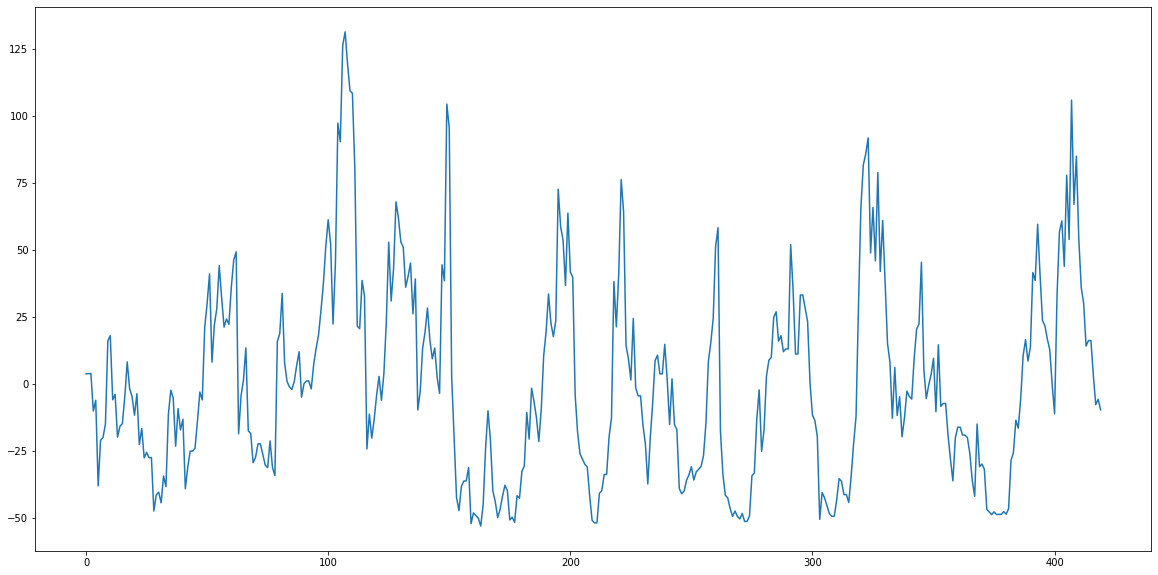

In [32]:
plt.plot(count)

In [ ]:
def min_MSE_finder_V(count, result_sst, link, df_sst, V, ratio=0.8, tau=-1, n_estimators=100, max_depth=5):
    result = []
#    link = link[link[:,1] <= tau]

    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    df = df.dropna()
    index = int(df.shape[0]*ratio)
    dim = df.shape[1]
    #index +=tau

    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim]
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0]
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))


    for z in range(len(link)):
        df = pd.DataFrame({"drought":count, "drought1":count})
        df.drought1 = df.drought1.shift(abs(tau))
        for k in range(0,z+1):
                df_sst["pc"] = V[:,link[k,0]-1]
                df[str(k)] = time_series_maker_V(result_sst, V[:,link[k,0]-1])
                df[str(k)] = df[str(k)].shift(abs(link[k,1]))
        df = df.dropna()
        index = int(df.shape[0]*ratio)
        #dim = df.shape[1]
        #index +=tau

        x_train, x_test = df.iloc[:index,1:], df.iloc[index:,1:]
        y_train, y_test = df.iloc[:index,0], df.iloc[index:,0]
        model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        result.append(mean_squared_error(y_pred, y_test))
    return(result,link)


In [ ]:
def min_MSE_finder1(count, result_sst, link,n_estimators=100, max_depth=5, tau=-1):
    result =[]
    link = link[link[:,1] <= tau]
    refined_link = []
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]

    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))


    for z in range(len(link)):
        df = pd.DataFrame({"drought":count, "drought1":count})
        df.drought1 = df.drought1.shift(abs(tau))
        for k in range(0,z+1):
                if link[k,0] != 0:
                    df[str(link[k,0]-1)] = result_sst[:,link[k,0]-1]
                    df[str(link[k,0]-1)] = df[str(link[k,0]-1)].shift(abs(link[k,1]))
                else:
                    df[str(link[k,0])] = count
                    df[str(link[k,0])] = df[str(link[k,0])].shift(abs(link[k,1]))
        df = df.dropna()
        index = int(df.shape[0]*0.7)
        dim = df.shape[1]

        x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
        y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
        model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_pred, y_test)
        if mse < result[-1]:
            result.append(mean_squared_error(y_pred, y_test))
            refined_link.append(link[z])
    return(result, np.array(refined_link))

In [3]:
train_start = 1990
train_end = 1996
test_start = train_end + 1
test_end = train_start + 8

tau = -6

In [4]:
temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(train_end, 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries("ET_gamma_18912015.npy",train_start,train_end)
data_sst, ts, V, df_sst, avg, std = ff.PCA_computer('../../../nc/sst.mnmean.nc', "sst",temporal_limits, 10, -9.96921e+36)
link = PCMCI_generator_GPDC(ts,count,tau_min = 0, tau_max=2)

NameError: name 'PCMCI_generator_GPDC' is not defined

In [35]:
temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(train_end, 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries("../ET_gamma_18912015.npy",train_start,train_end)
data_sst, ts, V, df_sst, avg, std = ff.PCA_computer('../../../nc/sst.mnmean.nc', "sst",temporal_limits, 10, -9.96921e+36)
link = ff.PCMCI_generator(ts,count)

In [46]:
    result_extremes = np.array(count)
    result_extremes = result_extremes.reshape((-1,1))
    componenet = []
    lag = []
    result_sst = np.array(ts)

In [56]:
result_sst[:,0].shape

(83,)

In [50]:
len(count)

83

In [53]:
result_extremes.shape

(83, 1)

In [78]:
def granger_generator(ts, count, test_type = "all", tau_min = 1, tau_max = 12,level = 0.05):
    result_extremes = np.array(count)
    result_extremes = result_extremes.reshape((-1,1))
    componenet = []
    lag = []
    result_sst = np.array(ts)
    
    for i in range(result_sst.shape[1]):
        sst = result_sst[:,i].reshape((-1,1))
        data = np.concatenate((result_extremes,sst), axis=1)
        data = np.array(data)
        df = pd.DataFrame(data)
        lag_range = range(tau_min, tau_max+1)
        r = grangercausalitytests(df,maxlag=lag_range,  verbose=False)
        p = np.zeros(4)
        for j in lag_range:
            p[0] = r[j][0]['lrtest'][1]
            p[1] = r[j][0]['params_ftest'][1]
            p[2] = r[j][0]['ssr_chi2test'][1]
            p[3] = r[j][0]['ssr_ftest'][1]
            
            
            if test_type == "all" and np.all(p < level):
                componenet.append(i+1)
                lag.append(-j)
            elif test_type == 'lrtest' and p[0] < level:
                componenet.append(i+1)
                lag.append(-j)
            elif test_type == 'params_ftest' and p[1] < level:
                componenet.append(i+1)
                lag.append(-j)
            elif test_type == 'ssr_chi2test' and p[2] < level:
                componenet.append(i+1)
                lag.append(-j)
            elif test_type == 'ssr_ftest' and p[3] < level:
                componenet.append(i+1)
                lag.append(-j)
            
    link = np.array(list(zip((componenet),(lag))))    
    return(link)

In [89]:
l = granger_generator(ts, count)

In [88]:
l

array([[ 1, -5],
       [ 1, -7],
       [ 1, -8],
       [ 1, -9],
       [ 6, -2],
       [ 9, -1]])

In [37]:
link

array([[  3,  -8],
       [  4,  -4],
       [  6, -12],
       [ 10, -11],
       [  6, -11],
       [ 10,  -2],
       [  1, -10],
       [  4, -11]])

In [22]:
best_link, base_model, model = ff.best_link_finder(count, data_sst, link, df_sst, V, tau=tau, ratio = 0.8)

/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/feature_finder_station.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(x_train, y_train)


In [23]:
temporal_limits = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
data_sst = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits, avg, std, 12, -9.96921e+36)
original_count, count = ff.drought_timeseries("ET_gamma_18912015.npy",test_start,test_end)

In [24]:
best_link

array([[  3,  -8],
       [  6, -12],
       [ 10, -11],
       [  6, -11],
       [  1, -10],
       [  4, -11]])

In [25]:
ff.base_model_result(original_count, count, base_model, best_link, tau)

689.7655120514887

In [26]:
ff.model_result(original_count, count, data_sst, best_link, df_sst, V, model,tau)

251.48317178003376

In [129]:
def shift_df(df, start_lag = 1, end_lag = 12):
    lags = np.arange(start_lag,end_lag + 1)
    df = df.assign(**{
    '{} (t-{})'.format(col, t): df[col].shift(t)
    for t in lags
    for col in df
    })
    df = df.dropna()
    return(df)

In [29]:
train_start = np.arange(1926,1977,5)
train_end = np.arange(1955,2006,5)
validation_end = np.arange(1960,2011,5)


In [30]:
train_start

array([1926, 1931, 1936, 1941, 1946, 1951, 1956, 1961, 1966, 1971, 1976])

In [31]:
validation_end

array([1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010])

In [32]:
link

array([[  3,  -8],
       [  4,  -4],
       [  6, -12],
       [ 10, -11],
       [  6, -11],
       [ 10,  -2],
       [  1, -10],
       [  4, -11]])

In [136]:
count

array([  1,   1,   4,  12,  23,   7,   9,  27,   7, -76, -16,  -8,  -1,
        -4,  -3,   2,  -2,  -1,   2,  -3,   0,   2,  15])

In [137]:
df = pd.DataFrame({"drought":count})

In [140]:
shift_df(df,6,12)

,drought,drought (t-6),drought (t-7),drought (t-8),drought (t-9),drought (t-10),drought (t-11),drought (t-12)
12,-1,9.0,7.0,23.0,12.0,4.0,1.0,1.0
13,-4,27.0,9.0,7.0,23.0,12.0,4.0,1.0
14,-3,7.0,27.0,9.0,7.0,23.0,12.0,4.0
15,2,-76.0,7.0,27.0,9.0,7.0,23.0,12.0
16,-2,-16.0,-76.0,7.0,27.0,9.0,7.0,23.0
17,-1,-8.0,-16.0,-76.0,7.0,27.0,9.0,7.0
18,2,-1.0,-8.0,-16.0,-76.0,7.0,27.0,9.0
19,-3,-4.0,-1.0,-8.0,-16.0,-76.0,7.0,27.0
20,0,-3.0,-4.0,-1.0,-8.0,-16.0,-76.0,7.0
21,2,2.0,-3.0,-4.0,-1.0,-8.0,-16.0,-76.0


In [122]:
lags = np.arange(1,13)

In [123]:
df = df.assign(**{
    '{} (t-{})'.format(col, t): df[col].shift(t)
    for t in lags
    for col in df
})
df = df.dropna()

In [124]:
df

,drought,drought (t-1),drought (t-2),drought (t-3),drought (t-4),drought (t-5),drought (t-6),drought (t-7),drought (t-8),drought (t-9),drought (t-10),drought (t-11),drought (t-12)
12,-1,-8.0,-16.0,-76.0,7.0,27.0,9.0,7.0,23.0,12.0,4.0,1.0,1.0
13,-4,-1.0,-8.0,-16.0,-76.0,7.0,27.0,9.0,7.0,23.0,12.0,4.0,1.0
14,-3,-4.0,-1.0,-8.0,-16.0,-76.0,7.0,27.0,9.0,7.0,23.0,12.0,4.0
15,2,-3.0,-4.0,-1.0,-8.0,-16.0,-76.0,7.0,27.0,9.0,7.0,23.0,12.0
16,-2,2.0,-3.0,-4.0,-1.0,-8.0,-16.0,-76.0,7.0,27.0,9.0,7.0,23.0
17,-1,-2.0,2.0,-3.0,-4.0,-1.0,-8.0,-16.0,-76.0,7.0,27.0,9.0,7.0
18,2,-1.0,-2.0,2.0,-3.0,-4.0,-1.0,-8.0,-16.0,-76.0,7.0,27.0,9.0
19,-3,2.0,-1.0,-2.0,2.0,-3.0,-4.0,-1.0,-8.0,-16.0,-76.0,7.0,27.0
20,0,-3.0,2.0,-1.0,-2.0,2.0,-3.0,-4.0,-1.0,-8.0,-16.0,-76.0,7.0
21,2,0.0,-3.0,2.0,-1.0,-2.0,2.0,-3.0,-4.0,-1.0,-8.0,-16.0,-76.0


In [27]:
df = pd.DataFrame({"drought":count, "drought1":count})
df.drought1 = df.drought1.shift(abs(tau))
for k in range(len(best_link)):
    df_sst["pc"] = V[:,best_link[k,0]-1]
    df[str(k)] = ff.time_series_maker_V(data_sst, V[:,best_link[k,0]-1])
    df[str(k)] = df[str(k)].shift(abs(best_link[k,1]))
df = df.dropna()
x_test = df.iloc[:,1:]
y_test = df.iloc[:,0]

y_pred = model.predict(x_test)
y_pred = ff.addtrend(original_count[np.abs(best_link[:,1].min())], np.ravel(y_pred))
y_test = ff.addtrend(original_count[np.abs(best_link[:,1].min())], np.ravel(y_test.values))

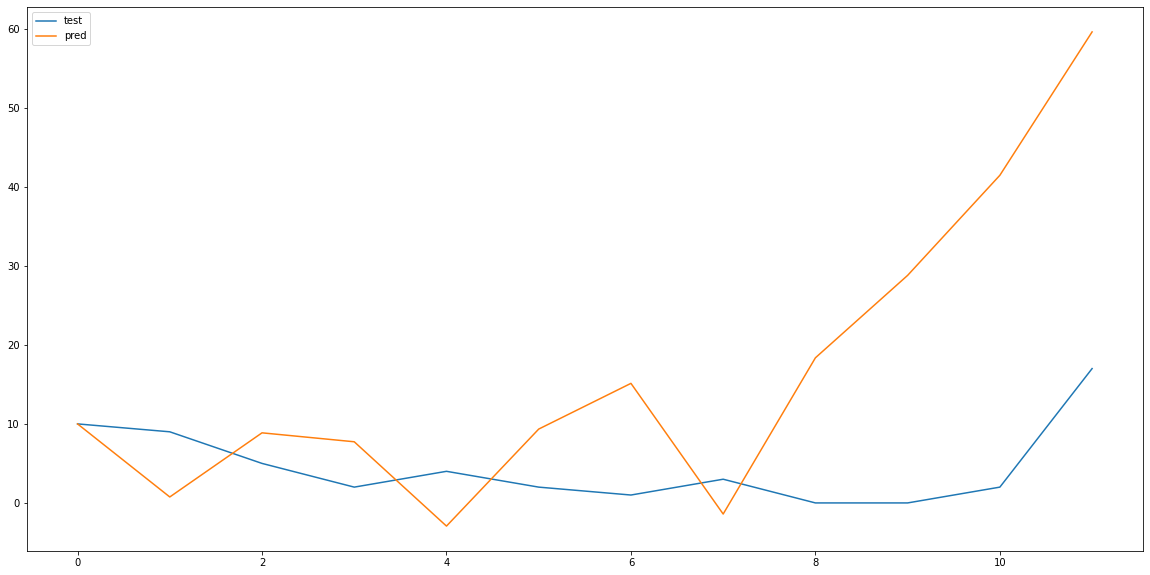

In [28]:
plt.plot(np.arange(len(y_test)),y_test, label="test")
plt.plot(np.arange(len(y_test)),y_pred, label="pred")
plt.legend()

In [ ]:
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    df = df.dropna()

    if len(best_link) > 0:
        best_link = np.array(best_link)
        start = np.abs(best_link[:,1].min() - tau)
    else:
        start = 0

    x_test =  df.iloc[start:,1].values
    y_test = df.iloc[start:,0].values
    x_test  = x_test.reshape(-1, 1)
    y_test  = y_test.reshape(-1, 1)

    y_pred = base_model.predict(x_test)
    y_pred = addtrend(original_count[np.abs(tau)+start], np.ravel(y_pred))
    y_test = addtrend(original_count[np.abs(tau)+start], np.ravel(y_test))

In [4]:
temporal_limits = {"time_min":datetime(1900, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0)}
count = ff1.drought_timeseries_agg("ET_gamma_18912015_agg.npy",1900,2015)
data_sst, ts, V, df_sst, avg, std = ff1.PCA_computer('../../../nc/sst.mnmean.nc', "sst",temporal_limits, 10, -9.96921e+36)

In [22]:
len(count)

264

In [23]:
len(data_sst)

1392

In [51]:
train_start = 1990
train_end = 1996
test_start = train_end + 1
test_end = train_start + 8

tau = -6

In [11]:
ET_gamma = np.load("ET_gamma_18912015.npy")

In [12]:
count = ff.drought_timeseries("ET_gamma_18912015.npy")

In [69]:
count1 = drought_timeseries("ET_gamma_18912015.npy",1922,1922)

In [156]:
train_start = np.arange(1926,1977,5)

In [157]:
train_end = np.arange(1955,2006,5)

In [158]:
validation_end = np.arange(1960,2011,5)

In [160]:
test_start = np.arange(1961,2012,5)

In [159]:
test_end = np.arange(1965,2016,5)

In [5]:
temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(train_end, 12, 1, 0, 0)}
count = ff1.drought_timeseries_agg("ET_gamma_18912015_agg.npy",train_start,train_end)
data_sst, ts, V, df_sst, avg, std = ff1.PCA_computer('../../../nc/sst.mnmean.nc', "sst",temporal_limits, 10, -9.96921e+36)
#link = ff1.PCMCI_generator(ts,count,tau_min = 0, tau_max = 12)

In [6]:
from scipy import stats

In [7]:
def crosscorr(datax, datay, lag=1):   
    return(stats.pearsonr(datax[lag:], datay[:-lag]))

In [101]:
def corr_generator(ts, count, tau_max = 12, level = 0.05):
    result_extremes = np.array(count)
    result_extremes = result_extremes.reshape((-1,1))

    result_sst = np.array(ts)

    data = np.concatenate((result_extremes,result_sst), axis=1)
    data = np.array(data)

    N = data.shape[1]-1
    result = np.zeros((tau_max,N))

    for j in range(1,N):
        for i in range(1,tau_max + 1):
            r, pvalue = crosscorr(data[:,0],data[:,j],lag=i)
            result[i-1,j] = r if pvalue < level else 0
      
    result = np.abs(result)
    #limit = np.percentile(result, percentile)
    limit = 0
    Index = np.where(result > limit)
    link = np.array(list(zip((Index[1]+1),(Index[0] + 1)*(-1)))) 
    result = result[Index]
    return(link[(-result).argsort()])

In [93]:
result

NameError: name 'result' is not defined

In [102]:
link = corr_generator(ts, count)

In [103]:
link

array([[  9,  -9],
       [  9,  -8],
       [  7,  -1],
       [  9, -10],
       [  6, -12],
       [  7,  -2],
       [  9,  -7],
       [  5,  -9],
       [  3, -12],
       [  5,  -8],
       [  5, -10],
       [  7,  -3],
       [  3, -11],
       [  6, -11],
       [  9, -11],
       [  5,  -7],
       [  3, -10],
       [  6,  -1],
       [  6,  -2],
       [  5, -11],
       [  9,  -6],
       [  7,  -4],
       [  2,  -7],
       [  2,  -6],
       [  2,  -8],
       [  2,  -9],
       [  2,  -5],
       [  2, -10],
       [  8,  -6],
       [  6,  -3],
       [  3,  -9],
       [  2,  -2],
       [  2,  -4],
       [  2,  -3],
       [  5,  -6],
       [  2,  -1],
       [  8,  -7],
       [  2, -11],
       [  8,  -5],
       [  5, -12],
       [  6, -10],
       [  7,  -5],
       [  3,  -8],
       [  9,  -1],
       [  6,  -4],
       [  8,  -4],
       [  2, -12],
       [  8,  -8],
       [  3,  -7],
       [  5,  -5],
       [  9, -12],
       [  9,  -5],
       [  8,

In [97]:
index = (-mag).argsort()

In [98]:
index

array([39, 35,  2, 44, 53,  6, 30, 38, 51, 33, 42,  9, 46, 48, 49, 28, 41,
        1,  5, 47, 25, 13, 26, 20, 31, 36, 15, 40, 24,  8, 37,  4, 11,  7,
       22,  0, 29, 45, 18, 52, 43, 17, 32,  3, 12, 14, 50, 34, 27, 16, 54,
       19, 10, 21, 23])

In [99]:
mag[index]

array([0.55565712, 0.53500017, 0.52703527, 0.5173064 , 0.5026704 ,
       0.4997847 , 0.47709818, 0.47652711, 0.47353659, 0.46238637,
       0.45585763, 0.45395006, 0.45184712, 0.4253277 , 0.41589947,
       0.41289494, 0.41168068, 0.41075227, 0.40381829, 0.40118033,
       0.39911637, 0.39297458, 0.3859581 , 0.38416965, 0.38295908,
       0.37943349, 0.37443711, 0.37069963, 0.36366121, 0.36237917,
       0.35805257, 0.35680349, 0.35655597, 0.35557418, 0.35060132,
       0.34764346, 0.34515935, 0.34226424, 0.33671384, 0.33576181,
       0.33045493, 0.32169617, 0.31606705, 0.31483972, 0.30078896,
       0.29664891, 0.29629469, 0.28007719, 0.27549394, 0.26938246,
       0.26286528, 0.26017009, 0.23956897, 0.23723712, 0.2239449 ])

In [91]:
link[index]

array([[  9,  -9],
       [  9,  -8],
       [  7,  -1],
       [  9, -10],
       [  6, -12],
       [  7,  -2],
       [  9,  -7],
       [  5,  -9],
       [  3, -12],
       [  5,  -8],
       [  5, -10],
       [  7,  -3],
       [  3, -11],
       [  6, -11],
       [  9, -11],
       [  5,  -7],
       [  3, -10],
       [  6,  -1],
       [  6,  -2],
       [  5, -11],
       [  9,  -6],
       [  7,  -4],
       [  2,  -7],
       [  2,  -6],
       [  2,  -8],
       [  2,  -9],
       [  2,  -5],
       [  2, -10],
       [  8,  -6],
       [  6,  -3],
       [  3,  -9],
       [  2,  -2],
       [  2,  -4],
       [  2,  -3],
       [  5,  -6],
       [  2,  -1],
       [  8,  -7],
       [  2, -11],
       [  8,  -5],
       [  5, -12],
       [  6, -10],
       [  7,  -5],
       [  3,  -8],
       [  9,  -1],
       [  6,  -4],
       [  8,  -4],
       [  2, -12],
       [  8,  -8],
       [  3,  -7],
       [  5,  -5],
       [  9, -12],
       [  9,  -5],
       [  8,

In [82]:
mag[::-1].argsort()

array([31, 33, 44, 35,  0, 38, 27, 20,  4, 40, 42, 51, 22, 37, 11,  2, 36,
        9, 25, 54, 32, 47, 43, 50, 17, 46, 30, 14, 39, 18, 23, 34, 28, 41,
       29,  7, 49, 53, 13, 26,  5,  6,  8, 45, 12, 21,  3, 16, 24, 48,  1,
       10, 52, 19, 15])

In [83]:
mag[4]

0.3568034949506978

In [77]:
mag[::-1].sort()
mag

array([0.55565712, 0.53500017, 0.52703527, 0.5173064 , 0.5026704 ,
       0.4997847 , 0.47709818, 0.47652711, 0.47353659, 0.46238637,
       0.45585763, 0.45395006, 0.45184712, 0.4253277 , 0.41589947,
       0.41289494, 0.41168068, 0.41075227, 0.40381829, 0.40118033,
       0.39911637, 0.39297458, 0.3859581 , 0.38416965, 0.38295908,
       0.37943349, 0.37443711, 0.37069963, 0.36366121, 0.36237917,
       0.35805257, 0.35680349, 0.35655597, 0.35557418, 0.35060132,
       0.34764346, 0.34515935, 0.34226424, 0.33671384, 0.33576181,
       0.33045493, 0.32169617, 0.31606705, 0.31483972, 0.30078896,
       0.29664891, 0.29629469, 0.28007719, 0.27549394, 0.26938246,
       0.26286528, 0.26017009, 0.23956897, 0.23723712, 0.2239449 ])

In [50]:
index

array([23, 21, 10, 19, 54, 16, 27, 34, 50, 14, 12,  3, 32, 17, 43, 52, 18,
       45, 29,  0, 22,  7, 11,  4, 37,  8, 24, 40, 15, 36, 31, 20, 26, 13,
       25, 47,  5,  1, 41, 28, 49, 48, 46,  9, 42, 33, 51, 38, 30,  6, 53,
       44,  2, 35, 39])

In [73]:
mag

array([0.34764346, 0.41075227, 0.52703527, 0.31483972, 0.35680349,
       0.40381829, 0.4997847 , 0.35557418, 0.36237917, 0.45395006,
       0.23956897, 0.35655597, 0.30078896, 0.39297458, 0.29664891,
       0.37443711, 0.26938246, 0.32169617, 0.33671384, 0.26017009,
       0.38416965, 0.23723712, 0.35060132, 0.2239449 , 0.36366121,
       0.39911637, 0.3859581 , 0.27549394, 0.41289494, 0.34515935,
       0.47709818, 0.38295908, 0.31606705, 0.46238637, 0.28007719,
       0.53500017, 0.37943349, 0.35805257, 0.47652711, 0.55565712,
       0.37069963, 0.41168068, 0.45585763, 0.33045493, 0.5173064 ,
       0.34226424, 0.45184712, 0.40118033, 0.4253277 , 0.41589947,
       0.29629469, 0.47353659, 0.33576181, 0.5026704 , 0.26286528])

In [26]:
i = (-res).argsort(axis=None)
j = np.unravel_index(i, res.shape)

In [22]:
j

(array([ 8,  7,  0,  9, 11,  1,  6,  8, 11,  7,  9,  2, 10, 10, 10,  6,  9,
         0,  1, 10,  5,  3,  6,  5,  7,  8,  4,  9,  5,  2,  8,  1,  3,  2,
         5,  0,  6, 10,  4, 11,  9,  4,  7,  0,  3,  3, 11,  7,  6,  4, 11,
         4,  2,  5,  5, 11,  7, 11, 11,  8, 11, 10, 10, 10,  8, 10,  9, 10,
         8,  8,  9,  9,  8,  9,  8,  9,  0,  5,  7,  2,  2,  2,  2,  2,  1,
         1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  2,  3,  3,  3,  7,  7,
         6,  6,  6,  6,  6,  5,  7,  5,  4,  4,  4,  4,  4,  3,  3,  3,  5,
        11]),
 array([8, 8, 6, 8, 5, 6, 8, 4, 2, 4, 4, 6, 2, 5, 8, 4, 2, 5, 5, 4, 8, 6,
        1, 1, 1, 1, 1, 1, 7, 5, 2, 1, 1, 1, 4, 1, 7, 1, 7, 4, 5, 6, 2, 8,
        5, 7, 1, 7, 2, 4, 8, 8, 7, 2, 6, 7, 9, 6, 3, 0, 0, 9, 7, 6, 3, 3,
        0, 0, 5, 9, 9, 7, 6, 6, 7, 3, 0, 9, 5, 8, 4, 3, 2, 0, 9, 8, 7, 4,
        3, 2, 0, 9, 7, 4, 3, 2, 9, 0, 2, 3, 3, 0, 9, 6, 5, 3, 0, 5, 6, 3,
        9, 5, 3, 2, 0, 9, 8, 4, 0, 9]))

In [41]:
    result_extremes = np.array(count)
    result_extremes = result_extremes.reshape((-1,1))

    result_sst = np.array(ts)

    data = np.concatenate((result_extremes,result_sst), axis=1)
    data = np.array(data)

In [45]:
    N = data.shape[1]-1
    result = np.zeros((tau_max,N))

In [54]:
level = 0.05

In [56]:
for j in range(1,N):
    for i in range(1,tau_max + 1):
        r, pvalue = crosscorr(data[:,0],data[:,j],lag=i)
        result[i-1,j] = r if pvalue < level else 0

In [60]:
result

array([[ 0.        , -0.34764346,  0.        ,  0.        ,  0.        ,
        -0.41075227, -0.52703527,  0.        ,  0.31483972,  0.        ],
       [ 0.        , -0.35680349,  0.        ,  0.        ,  0.        ,
        -0.40381829, -0.4997847 ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.35557418,  0.        ,  0.        ,  0.        ,
        -0.36237917, -0.45395006, -0.23956897,  0.        ,  0.        ],
       [ 0.        , -0.35655597,  0.        ,  0.        ,  0.        ,
        -0.30078896, -0.39297458, -0.29664891,  0.        ,  0.        ],
       [ 0.        , -0.37443711,  0.        ,  0.        ,  0.26938246,
         0.        , -0.32169617, -0.33671384, -0.26017009,  0.        ],
       [ 0.        , -0.38416965, -0.23723712,  0.        ,  0.35060132,
         0.        , -0.2239449 , -0.36366121, -0.39911637,  0.        ],
       [ 0.        , -0.3859581 , -0.27549394,  0.        ,  0.41289494,
         0.        ,  0.        , -0.34515935

In [48]:
N

10

In [43]:
tau_max=12

In [13]:
link

array([[  5,  -1],
       [  8,  -3],
       [  6,  -2],
       [  7, -11],
       [  4,  -2],
       [  1, -10],
       [  5,  -3],
       [  3,  -7]])

In [28]:
train_start = np.arange(1926,1977,5)
train_end = np.arange(1955,2006,5)
validation_end = np.arange(1960,2011,5)
test_start = np.arange(1961,2012,5)
test_end = np.arange(1965,2016,5)

n_components_sst = 76

taus = np.arange(1,13)

In [29]:
tau = 1

In [50]:
temporal_limits = {"time_min":datetime(train_start[0], 1, 1, 0, 0),"time_max":datetime(validation_end[0], 12, 1, 0, 0)}
count = ff1.drought_timeseries_agg("ET_gamma_18912015_agg.npy",train_start[0],validation_end[0])
data_sst, ts, V, df_sst, avg, std = ff1.PCA_computer('../../../nc/sst.mnmean.nc', "sst",temporal_limits, n_components_sst, -9.96921e+36)
#link = ff.PCMCI_generator(ts,count,tau_min = tau, tau_max = tau+12)

        #np.save("./link_agg/link_{}_{}_{}.npy".format(train_start[ijz],validation_end[ijz],tau), link)

In [51]:
    result_extremes = np.array(count)
    result_extremes = result_extremes.reshape((-1,1))

    result_sst = np.array(ts)

    result = np.concatenate((result_extremes,result_sst), axis=1)
    result = np.array(result)


In [52]:
dim, T = result.shape

In [53]:
result -= result.mean(axis=1).reshape(dim, 1)
result /= result.std(axis=1).reshape(dim, 1)

In [44]:
result[:,1]

array([ 2.37763801,  2.1330196 ,  2.59061029,  2.6375885 ,  2.3997045 ,
        2.09501556,  1.47866892,  0.9546601 ,  0.16063403, -0.12124147,
       -0.28462422, -0.74937872, -3.3510043 , -1.69698109, -3.87172426,
       -3.9302322 , -4.27831533, -4.16423002, -3.6153497 , -3.08502781,
       -2.44784578, -2.09369806, -0.39785897, -0.55521371, -0.40118154,
       -1.51987602, -2.42956022, -3.52698072, -3.02329001, -2.71100833,
       -3.15437387, -3.71662316, -3.98208783, -4.10871904, -3.20259537,
       -4.12469841, -4.11486974, -4.11873258, -4.1564113 , -3.43838276,
       -4.47151415, -4.29858669, -3.66202551, -3.37517372, -2.68028662,
       -2.54470076, -2.85415121, -1.72908979, -2.30739884, -2.67799314,
       -2.47489683, -1.21381592, -2.33096654, -2.08972526, -0.93572481,
       -0.24806213,  1.46399532,  1.86492598,  3.07218327,  2.28627414,
        2.97904117,  2.73810536,  2.86569441,  2.62395   ,  2.62454346,
        2.74438299,  1.94211118,  0.7447701 ,  0.7500981 ,  0.03

In [ ]:
            array -= array.mean(axis=1).reshape(dim, 1)
            array /= array.std(axis=1).reshape(dim, 1)

In [21]:
a = (count - count.mean())/count.std()

In [54]:
np.isnan(result).sum()

0

In [24]:
count = ff1.drought_timeseries_agg("ET_gamma_18912015_agg.npy",1926,1960)

In [47]:
result[389,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [49]:
count[389]

-inf

In [45]:
np.where(np.isnan(result))

(array([389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389,
        389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389,
        389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389,
        389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389,
        389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389,
        389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76]))

In [71]:
best_link, base_model, model = ff1.best_link_finder(count, data_sst, link, df_sst, V, tau=tau, ratio = 0.8)

/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/feature_finder_f.py:393: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(x_train, y_train)


In [72]:
temporal_limits = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
data_sst = ff1.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits, avg, std, 12, -9.96921e+36)
count = ff1.drought_timeseries("ET_gamma_18912015.npy",test_start,test_end)

In [73]:
ff1.base_model_result(count, base_model,  best_link, tau)

1318.79836087257

In [74]:
ff1.model_result_V(count, data_sst, best_link, df_sst, V, model,tau)

7278.070799154312

In [75]:
ff1.model_result_V(count, data_sst, best_link, df_sst, V, model,tau)

7278.070799154312

In [76]:
best_link

array([[  2, -12],
       [  3,  -8],
       [  2, -17],
       [  1, -14],
       [  5,  -7]])

In [77]:
link

array([[  6, -19],
       [  2,  -6],
       [  2, -12],
       [  7, -18],
       [  7,  -5],
       [  3,  -4],
       [  5, -21],
       [  3,  -8],
       [ 10,  -7],
       [  2, -17],
       [  8,  -4],
       [  1, -14],
       [  5, -16],
       [  7, -10],
       [  5,  -7],
       [  2, -23],
       [  4, -20]])

In [79]:
tau - 12

-18

In [5]:
temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(train_end, 12, 1, 0, 0)}
count = ff1.drought_timeseries("ET_gamma_18912015.npy",train_start,train_end)
data_sst, ts, df_sst, avg, std = ff1.clustering_computer('../../../nc/sst.mnmean.nc', "sst",temporal_limits, 10, -9.96921e+36)
link = ff1.PCMCI_generator(ts,count,12)

In [7]:
best_link, base_model, model = ff1.best_link_finder_cluster(count, data_sst, link, df_sst, tau=tau, ratio = 0.8)

/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/feature_finder1.py:500: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(x_train, y_train)


In [8]:
temporal_limits = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
data_sst = ff1.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits, avg, std, 12, -9.96921e+36)
count = ff1.drought_timeseries("ET_gamma_18912015.npy",test_start,test_end)

In [10]:
ff1.base_model_result(count, base_model,best_link, tau)

1607.815763001509

In [11]:
ff1.model_result_cluster(count, data_sst, best_link, df_sst, model,tau)

1551.6912228370181

In [14]:
temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(train_end, 12, 1, 0, 0)}
count = ff1.drought_timeseries("ET_gamma_18912015.npy",train_start,train_end)
data_sst, ts, V, df_sst, avg, std = ff1.PCA_computer('../../../nc/sst.mnmean.nc', "sst",temporal_limits, 10, -9.96921e+36)
link = ff1.corr_generator(ts, count, tau_max = 12, percentile = 90)

In [15]:
best_link, base_model, model = ff1.best_link_finder_V(count, data_sst, link, df_sst, V, tau=tau, ratio = 0.8)

/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/feature_finder1.py:447: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(x_train, y_train)


In [16]:
temporal_limits = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
data_sst = ff1.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits, avg, std, 12, -9.96921e+36)
count = ff1.drought_timeseries("ET_gamma_18912015.npy",test_start,test_end)

In [18]:
ff1.base_model_result(count, base_model,best_link, tau)

1607.815763001509

In [17]:
ff1.model_result(count, data_sst, best_link, df_sst, V, model, tau)

745.5294158758609

In [60]:
temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(train_end, 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries("ET_gamma_18912015.npy",train_start,train_end)
data_sst, ts, V_old, df_sst, avg, std = ff.PCA_computer('../../../nc/sst.mnmean.nc', "sst",temporal_limits,10, -9.96921e+36)
link = ff.PCMCI_generator(ts, count)

KeyboardInterrupt: 

In [4]:
temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(train_end, 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries("ET_gamma_18912015.npy",train_start,train_end)
data_sst, ts, V, df_sst, avg, std = ff.PCA_computer('../../../nc/sst.mnmean.nc', "sst",temporal_limits,10, -9.96921e+36)
link = ff.PCMCI_generator(ts, count)

best_link, base_model, model = ff.best_link_finder(count, data_sst, link, df_sst, V, tau=tau, ratio = 0.8)

temporal_limits = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
data_sst = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits,avg, std, 12, -9.96921e+36)
original_count, count = ff.drought_timeseries("ET_gamma_18912015.npy",test_start,test_end)

/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/feature_finder_station.py:329: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(x_train, y_train)


In [5]:
ff.base_model_result(original_count,count, base_model, best_link,tau)

689.7655120514887

In [6]:
ff.model_result(original_count, count, data_sst, best_link, df_sst, V, model,tau)

251.48317178003376

In [7]:
temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(train_end, 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries("ET_gamma_18912015.npy",train_start,train_end)
data_sst, ts, V, df_sst, avg, std = ff.PCA_computer('../../../nc/sst.mnmean.nc', "sst",temporal_limits,10, -9.96921e+36)
link = ff.corr_generator(ts, count, tau_max = 12, percentile = 90)

best_link, base_model, model = ff.best_link_finder(count, data_sst, link, df_sst, V, tau=tau, ratio = 0.8)

temporal_limits = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
data_sst = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits,avg, std, 12, -9.96921e+36)
original_count, count = ff.drought_timeseries("ET_gamma_18912015.npy",test_start,test_end)


/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/feature_finder_station.py:329: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(x_train, y_train)


In [8]:
ff.base_model_result(original_count,count, base_model, best_link,tau)

2808.075846799965

In [9]:
ff.model_result(original_count, count, data_sst, best_link, df_sst, V, model,tau)

13333.783179196584

In [7]:
temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(train_end, 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries("ET_gamma_18912015.npy",train_start,train_end)
data_sst, ts, df_sst, avg, std = ff.clustering_computer('../../../nc/sst.mnmean.nc', "sst",temporal_limits, 10, -9.96921e+36)
link = ff.PCMCI_generator(ts,count,12)

best_link, base_model, model = ff.best_link_finder_cluster(count, data_sst, link, df_sst, tau=tau, ratio = 0.8)

temporal_limits = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
data_sst = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits, avg, std, 12, -9.96921e+36)
original_count, count = ff.drought_timeseries("ET_gamma_18912015.npy",test_start,test_end)

/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/feature_finder_station.py:481: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(x_train, y_train)


In [11]:
best_link

[]

In [9]:
ff.base_model_result(original_count, count, base_model, best_link,tau)

TypeError: list indices must be integers or slices, not tuple

In [10]:
model_result_cluster(original_count, count, data_sst, best_link, df_sst, V, model,tau)

NameError: name 'V' is not defined

In [8]:
def model_result_cluster(original_count, count, data_sst, best_link, df_sst, model, tau=-1, n_estimators=100, max_depth=5):
    if len(best_link) > 0:
        df = pd.DataFrame({"drought":count, "drought1":count})
        df.drought1 = df.drought1.shift(abs(tau))
        for k in range(len(best_link)):
            #df_sst["pc"] = V[:,best_link[k,0]-1]
            #df[str(best_link[k,0]-1)] = time_series_maker_V(data_sst, V[:,best_link[k,0]-1])
            #df[str(best_link[k,0]-1)] = df[str(best_link[k,0]-1)].shift(abs(best_link[k,1]))
            df[str(k)] = time_series_maker_cluster(data_sst, df_sst, best_link[k,0]-1)
            df[str(k)] = df[str(k)].shift(abs(best_link[k,1]))
        df = df.dropna()
        x_test = df.iloc[:,1:]
        y_test = df.iloc[:,0]

        y_pred = model.predict(x_test)
        y_pred = addtrend(original_count[np.abs(best_link[:,1].min())], np.ravel(y_pred))
        y_test = addtrend(original_count[np.abs(best_link[:,1].min())], np.ravel(y_test.values))
        return(mean_squared_error(y_pred, y_test))
    else:
        return(np.nan)

In [23]:
mse

689.7655120514887

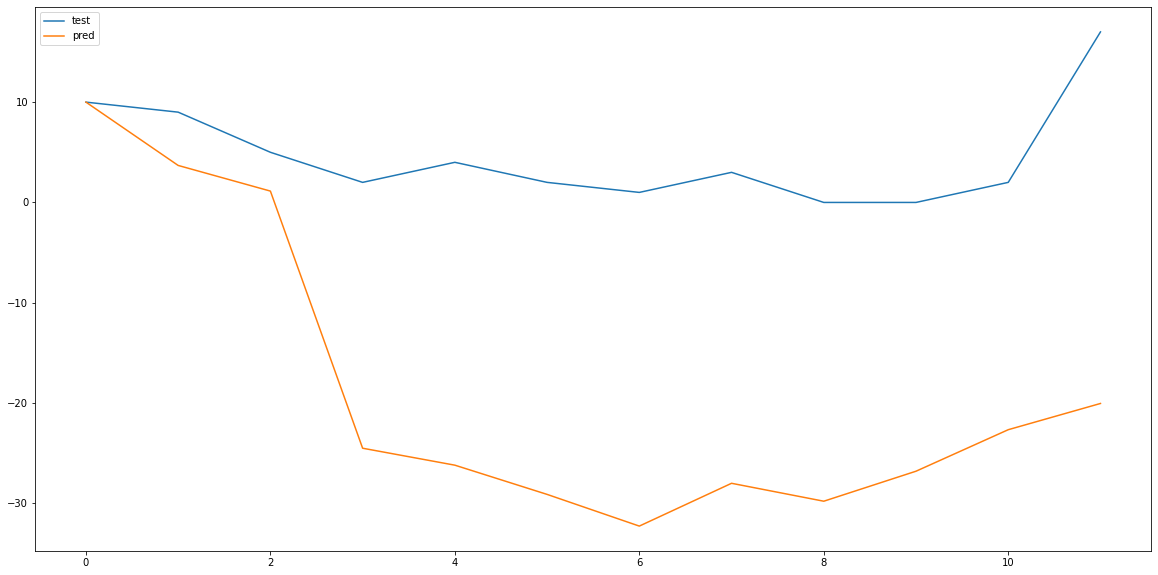

In [25]:
plt.plot(y_test, label = "test")
plt.plot(y_pred, label = "pred")
plt.legend()

In [24]:
y_test

[10, 9, 5, 2, 4, 2, 1, 3, 0, 0, 2, 17]

In [36]:
y_pred

[10,
 11.974639820900428,
 13.561208060604276,
 13.756090227323138,
 14.469594991445234,
 19.103073245348902,
 25.90560622686451,
 29.487056233242296,
 32.83894050463043,
 35.80443813005583,
 39.1438286826521,
 42.156528689029884]

In [27]:
mse, y_test, y_pred, df = ff.model_result_V(original_count, count, data_sst, best_link, df_sst, V, model,tau)

In [28]:
mse

5560.856150031293

In [29]:
y_test

[10, 9, 5, 2, 4, 2, 1, 3, 0, 0, 2, 17]

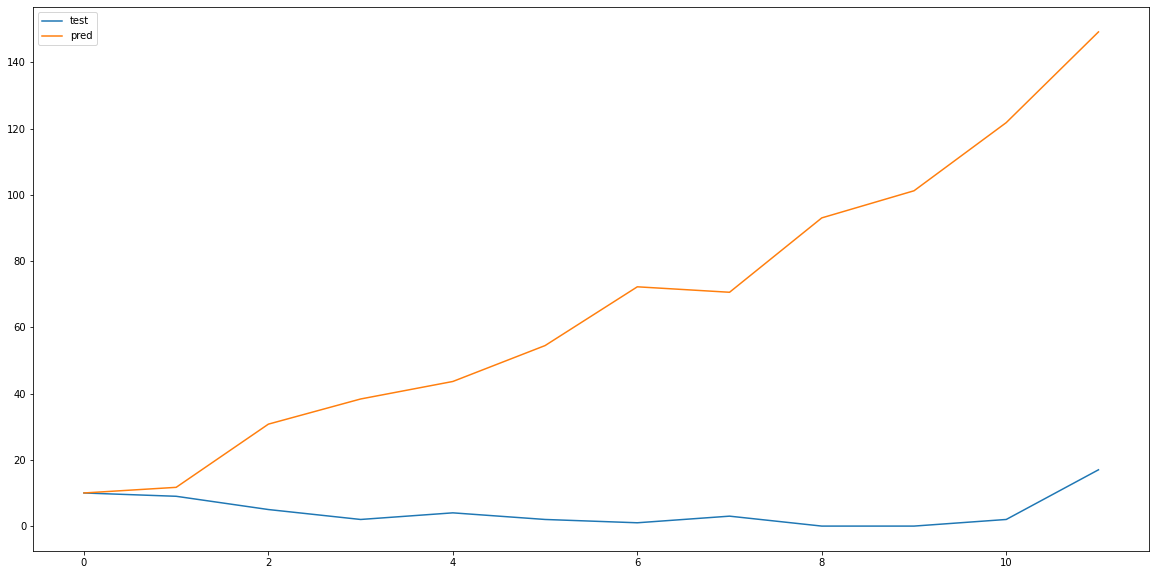

In [30]:
plt.plot(y_test, label = "test")
plt.plot(y_pred, label = "pred")
plt.legend()

In [32]:
mse, y_test, y_pred, df = ff.model_result(original_count, count, data_sst, best_link, df_sst, V, model,tau)

In [33]:
mse

526.4331728557572

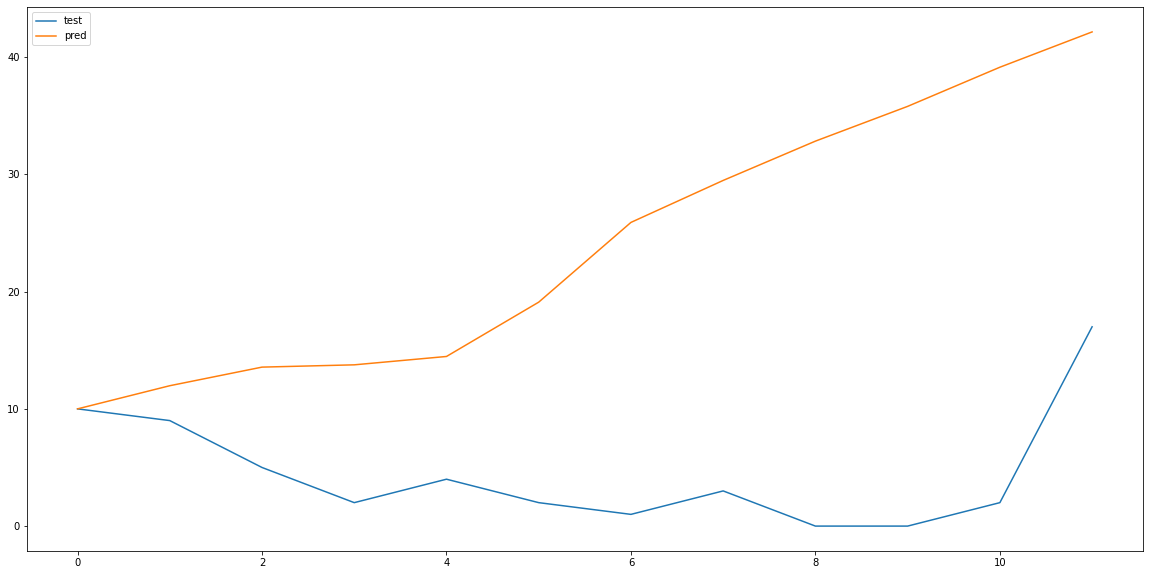

In [34]:
plt.plot(y_test, label = "test")
plt.plot(y_pred, label = "pred")
plt.legend()

In [35]:
y_test

[10, 9, 5, 2, 4, 2, 1, 3, 0, 0, 2, 17]

In [5]:
temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(train_end, 12, 1, 0, 0)}
count = ff1.drought_timeseries("ET_gamma_18912015.npy",train_start,train_end)
data_sst, ts, V, df_sst, avg, std = ff1.PCA_computer('../../../nc/sst.mnmean.nc', "sst",temporal_limits,10, -9.96921e+36)
link = ff1.PCMCI_generator(ts,count,12)

best_link, base_model, model = ff1.best_link_finder_V(count, data_sst, link, df_sst, V, tau=tau, ratio = 0.8)

temporal_limits = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
data_sst = ff1.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits, avg, std, 12, -9.96921e+36)
count = ff1.drought_timeseries("ET_gamma_18912015.npy",test_start,test_end)

/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/feature_finder1.py:412: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(x_train, y_train)


In [6]:
mse, y_test, y_pred, df = ff1.base_model_result(count, base_model, best_link,tau)

In [7]:
df

,drought,drought1
6,67,19.0
7,76,20.0
8,103,21.0
9,110,25.0
10,34,37.0
11,18,60.0
12,10,67.0
13,9,76.0
14,5,103.0
15,2,110.0


In [8]:
y_test

array([[34],
       [18],
       [10],
       [ 9],
       [ 5],
       [ 2],
       [ 4],
       [ 2],
       [ 1],
       [ 3],
       [ 0],
       [ 0],
       [ 2],
       [17]])

In [9]:
mse

1607.815763001509

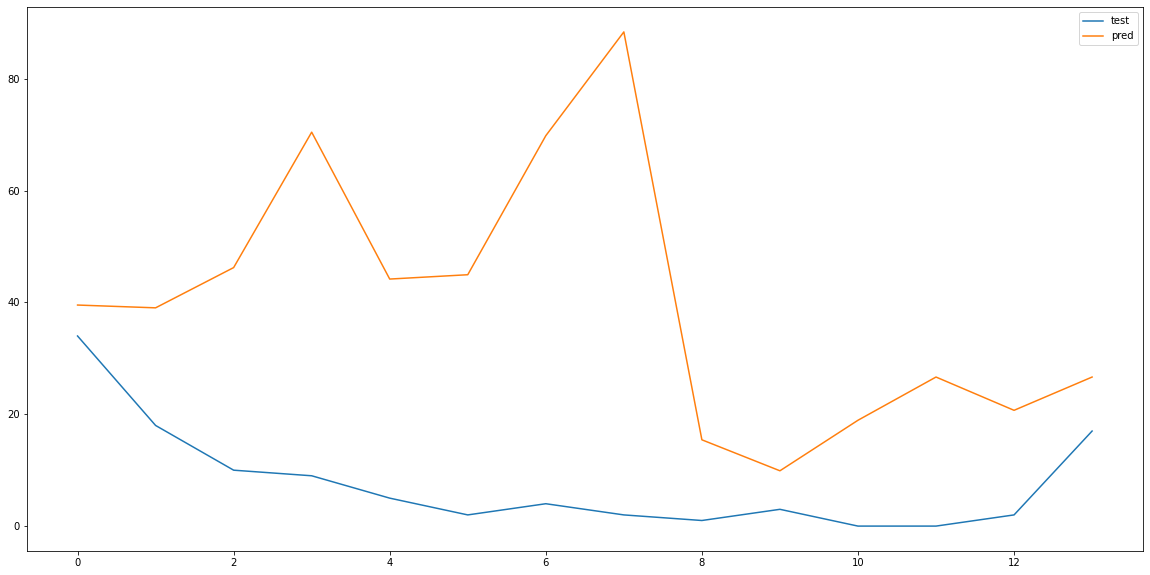

In [10]:
plt.plot(y_test, label = "test")
plt.plot(y_pred, label = "pred")
plt.legend()

In [11]:
mse, y_test, y_pred, df = ff1.model_result_V(count, data_sst, best_link, df_sst, V, model,tau)

In [12]:
df

,drought,drought1,0,1
10,34,37.0,-2558.718829,78075.703377
11,18,60.0,139297.238562,9773.367694
12,10,67.0,36412.132119,-97808.691829
13,9,76.0,-2673.077807,9379.291641
14,5,103.0,43725.566389,-45074.018261
15,2,110.0,57615.026112,-122436.006570
16,4,34.0,-6.287040,-94528.098262
17,2,18.0,-12.717972,-0.050563
18,1,10.0,-6967.973959,8.004122
19,3,9.0,122803.149009,16976.017624


In [13]:
mse

2186.981020828566

In [14]:
y_test

10    34
11    18
12    10
13     9
14     5
15     2
16     4
17     2
18     1
19     3
20     0
21     0
22     2
23    17
Name: drought, dtype: int64

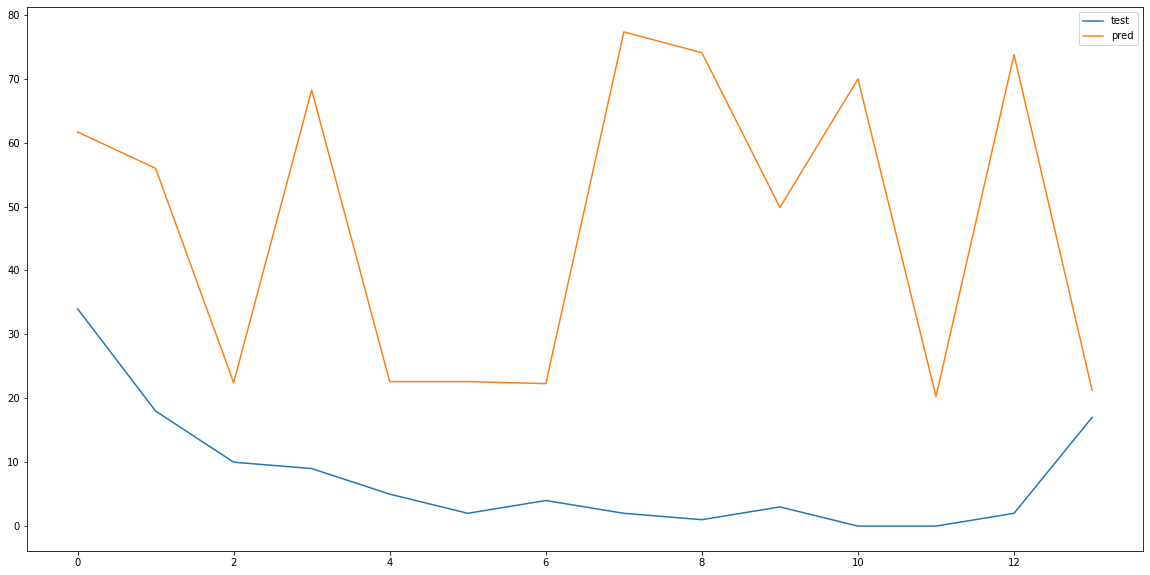

In [15]:
plt.plot(y_test.values, label = "test")
plt.plot(y_pred, label = "pred")
plt.legend()

In [16]:
mse, y_test, y_pred, df = ff1.model_result(count, data_sst, best_link, df_sst, V, model,tau)

In [17]:
df

,drought,drought1,0,1
10,34,37.0,-0.016384,-0.364805
11,18,60.0,-0.590680,-0.718708
12,10,67.0,-0.891311,-0.740078
13,9,76.0,-0.146635,-1.179366
14,5,103.0,-0.150674,-0.716021
15,2,110.0,0.121819,-0.669542
16,4,34.0,0.379112,-0.132752
17,2,18.0,0.573399,0.242943
18,1,10.0,0.229688,0.436883
19,3,9.0,0.339595,1.325093


In [18]:
y_test.values

array([34, 18, 10,  9,  5,  2,  4,  2,  1,  3,  0,  0,  2, 17])

In [19]:
y_pred

array([72.95763422, 54.46910752, 69.98086816, 67.55021359, 52.05658661,
       59.15818834, 78.66347945, 82.36263441, 81.94935663, 77.84313227,
       76.41204894, 73.76060197, 74.59290966, 74.51790966])

In [18]:
mse

2850.313488635153

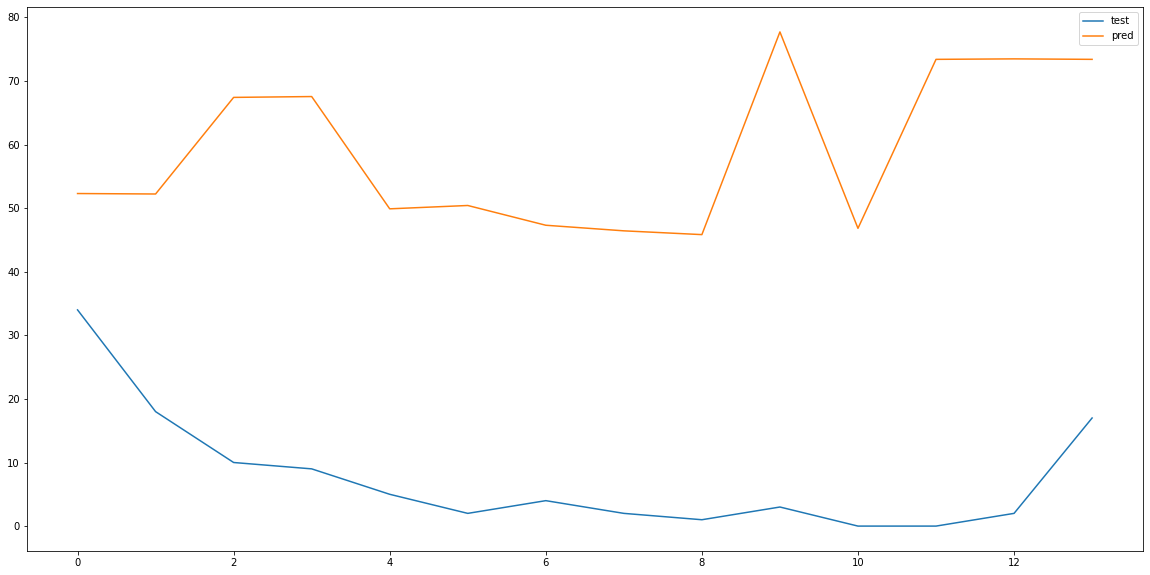

In [44]:
plt.plot(y_test.values, label = "test")
plt.plot(y_pred, label = "pred")
plt.legend()

In [48]:
data_sst.shape

(23, 10988)

In [45]:
adfuller(data_sst[:,10])

(-5.842397186880264,
 3.750846354762553e-07,
 0,
 22,
 {'1%': -3.769732625845229,
  '10%': -2.6425009917355373,
  '5%': -3.005425537190083},
 11.471989725956192)

In [6]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return(np.array(diff))

In [102]:
ts = difference(ts)

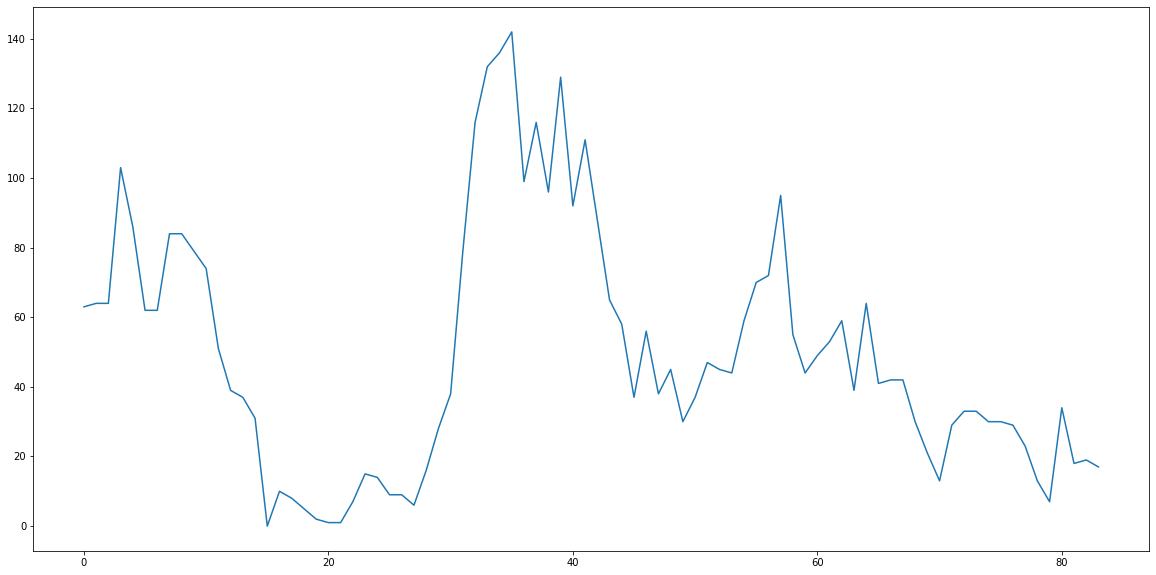

In [27]:
plt.plot(original_count)

In [5]:
tau = -6
#best_link, base_model, model = ff.best_link_finder_cluster(count, data_sst, link, df_sst, tau=tau)
best_link, base_model, model = ff.best_link_finder_V(count, data_sst, link, df_sst, V, tau=tau, ratio = 0.8)

/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/feature_finder_station.py:260: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(x_train, y_train)


In [6]:
temporal_limits = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
data_sst = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits,avg, std, 12, -9.96921e+36)
#data_sst = ff.data_generator('../../../nc/sst.mnmean.nc', "sst",temporal_limits, -9.96921e+36)
original_count, count = ff.drought_timeseries("ET_gamma_18912015.npy",test_start,test_end)

In [127]:
sst = Data('../../sst.mnmean.nc','sst',temporal_limits)

result = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()

result_sst, avgs, stds = pf.deseasonalize_avg_std(np.array(result))
weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
for i in range(len(weights)):
    result_sst[:,i] = weights[i] * result_sst[:,i]

In [133]:
temp = np.array(result_sst)
clustering = AgglomerativeClustering(n_clusters=n_components_sst).fit(np.transpose(temp))

In [137]:
df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list,"clusters":clustering.labels_})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

In [ ]:
df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clustering.labels_})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

In [ ]:
cluster_data = []
for i in range(n_components):
    Idx = np.where((df.clusters == i).values)[0]
    r = result[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)
    pca = PCA(n_components=n_components)
    pca_model = pca.fit(scaled_data)
    pca_data = pca_model.transform(data)
    cluster_data.append(pca_data[:,0])

In [4]:
#temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(train_end, 12, 1, 0, 0)}
#data_sst = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits, avg, std, 12, -9.96921e+36)
#data_sst = ff.data_generator('../../../nc/sst.mnmean.nc', "sst",temporal_limits, -9.96921e+36)
#data_sst = ff.data_generator_deseasonalized('../../../nc/sst.mnmean.nc', "sst",temporal_limits, -9.96921e+36)
#count = ff.drought_timeseries("ET_gamma_18912015.npy",train_start,train_end)
Index = 60
tau = -12
best_link, base_model, model = ff.best_link_finder_V(count, data_sst, link, df_sst, V, index = Index , tau=tau)

/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/feature_finder.py:411: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(x_train, y_train)


In [5]:
temporal_limits = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
data_sst = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits,avg, std, 12, -9.96921e+36)
#data_sst = ff.data_generator('../../../nc/sst.mnmean.nc', "sst",temporal_limits, -9.96921e+36)
count = ff.drought_timeseries("ET_gamma_18912015.npy",test_start,test_end)

In [22]:
with open("list_{}.txt".format(np.abs(tau)), "a") as myfile:
    for p in range(len(link)):
        myfile.write(str(link[p,:])+"\n")
    myfile.write("***\n")

In [7]:
ff.base_model_result(original_count, count, base_model, tau)

1181.5892451963307

In [8]:
ff.model_result_cluster(count, data_sst, best_link, df_sst, model,tau)

AttributeError: module 'feature_finder_station' has no attribute 'model_result_cluster'

In [9]:
ff.base_model_result(original_count,count, base_model, tau)

1181.5892451963307

In [10]:
ff.model_result_V(original_count, count, data_sst, best_link, df_sst, V, model,tau)

9828.733781973831

In [11]:
ff.model_result(original_count, count, data_sst, best_link, df_sst, V, model,tau)

4515.144234827257

In [12]:
data_sst.shape

(24, 10988)

In [9]:
ff.model_result(count, data_sst, best_link, df_sst, V, model,tau)

1377.366962279974

In [19]:
V.shape

(10988, 10)

In [ ]:
def time_series_maker_V(data, V_value):
    return(np.ravel(np.matmul(data,V_value)))

def model_result_V(count, data_sst, best_link, df_sst, V,model, tau=-1, n_estimators=100, max_depth=5):
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    for k in range(len(best_link)):
        df_sst["pc"] = V[:,best_link[k,0]-1]
        df[str(best_link[k,0]-1)] = time_series_maker_V(data_sst, V[:,best_link[k,0]-1])
        df[str(best_link[k,0]-1)] = df[str(best_link[k,0]-1)].shift(abs(best_link[k,1]))
    df = df.dropna()


    x_test = df.iloc[:,1:]
    y_test = df.iloc[:,0]

    y_pred = model.predict(x_test)
    return(mean_squared_error(y_pred, y_test))

In [135]:
def base_model_result(count, base_model, tau=-1):
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    df = df.dropna()

    x_test =  df.iloc[:,1].values
    y_test = df.iloc[:,0].values
    x_test  = x_test.reshape(-1, 1)
    y_test  = y_test.reshape(-1, 1)

    y_pred = base_model.predict(x_test)
    return(mean_squared_error(y_pred, y_test))

In [136]:
def model_result(count, data_sst, best_link, df_sst, V,model, tau=-1, n_estimators=100, max_depth=5):
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    for k in range(len(best_link)):
        df_sst["pc"] = V[:,best_link[k,0]-1]
        df[str(best_link[k,0]-1)] = time_series_maker(best_link[k,0]-1, df_sst, data_sst)
        df[str(best_link[k,0]-1)] = df[str(best_link[k,0]-1)].shift(abs(best_link[k,1]))
    df = df.dropna()


    x_test = df.iloc[:,1:]
    y_test = df.iloc[:,0]

    y_pred = model.predict(x_test)
    return(mean_squared_error(y_pred, y_test))

In [112]:
df = pd.DataFrame({"drought":count, "drought1":count})
df.drought1 = df.drought1.shift(abs(tau))
df = df.dropna()

x_test =  df.iloc[:,1:].values
y_test = df.iloc[:,0].values
x_test  = x_train.reshape(-1, 1)
y_test  = y_train.reshape(-1, 1)

y_pred = base_model.predict(x_test)
mean_squared_error(y_pred, y_test)

600.2538395881187

In [110]:
df = pd.DataFrame({"drought":count, "drought1":count})
df.drought1 = df.drought1.shift(abs(tau))
for k in range(len(best_link)):
    df_sst["pc"] = V[:,best_link[k,0]-1]
    df[str(best_link[k,0]-1)] = time_series_maker(best_link[k,0]-1, df_sst, data_sst)
    df[str(best_link[k,0]-1)] = df[str(best_link[k,0]-1)].shift(abs(best_link[k,1]))
df = df.dropna()


x_test = df.iloc[:,1:]
y_test = df.iloc[:,0]

y_pred = model.predict(x_test)
mean_squared_error(y_pred, y_test)

895.4688967489334

In [141]:
def best_link_finder(count, data_sst, link, df_sst, V, index = 60 , tau=-1, n_estimators=100, max_depth=5):
    
    result, link = min_MSE_finder_index(count, data_sst, link, df_sst, V, index,tau)
    
    overall_min_MSE = []
    overall_min_MSE.append(min(result))
    
    link_list = []
    diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
    refined_index = np.array(diff) < 0 
    while not all(refined_index):
        link_list.append(link)
        link = link[refined_index,:]
        result, link = min_MSE_finder_index(count, data_sst, link, df_sst, V, index, tau)
        overall_min_MSE.append(min(result))
        diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
        refined_index = np.array(diff) < 0
        
    
    best_index = np.where(np.array(overall_min_MSE) == np.array(overall_min_MSE).min())[0][-1]
    best_link = link_list[best_index-1]
    
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    df = df.dropna()
    dim = df.shape[1]
    index +=tau

    x_train =  df.iloc[:,1:].values
    y_train = df.iloc[:,0].values
    x_train  = x_train.reshape(-1, 1)
    y_train  = y_train.reshape(-1, 1)
    base_model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    base_model.fit(x_train, y_train)
    
    
    
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    for k in range(len(best_link)):
        df_sst["pc"] = V[:,best_link[k,0]-1]
        df[str(best_link[k,0]-1)] = time_series_maker(best_link[k,0]-1, df_sst, data_sst)
        df[str(best_link[k,0]-1)] = df[str(best_link[k,0]-1)].shift(abs(best_link[k,1]))
    df = df.dropna()
    index +=tau
    
    x_train = df.iloc[:,1:]
    y_train = df.iloc[:,0]
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)

    return(best_link, base_model, model)

In [140]:
def time_series_maker(pc, df_sst, result, level = 95): 
    if np.abs(df_sst.pc.values.min()) > np.abs(df_sst.pc.values.max()):
        limit = np.percentile(df_sst.pc.values, 1 - level)
        df_sst.pc.values[df_sst.pc.values>=limit]=np.nan
    else:
        limit = np.percentile(df_sst.pc.values, level)
        df_sst.pc.values[df_sst.pc.values<=limit]=np.nan

    I = np.where(~np.isnan(df_sst.pc.values))[0]

    d = result[:,I].mean(axis=1)
    d = np.ravel(d)
    d = np.reshape(d,(-1,1))
    d = pf.deseasonalize(d)
    d = np.ravel(d)
    return(d)
    
def min_MSE_finder_index(count, result_sst, link,df_sst, V, index = 60 , tau=-1, n_estimators=100, max_depth=5):
    result = []
    link = link[link[:,1] <= tau]

    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    df = df.dropna()
    #index = int(df.shape[0]*0.7)
    dim = df.shape[1]
    index +=tau

    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))


    for z in range(len(link)):
        df = pd.DataFrame({"drought":count, "drought1":count})
        df.drought1 = df.drought1.shift(abs(tau))
        for k in range(0,z+1):
                df_sst["pc"] = V[:,link[k,0]-1]
                df[str(link[k,0]-1)] = time_series_maker(link[k,0]-1, df_sst, result_sst)
                df[str(link[k,0]-1)] = df[str(link[k,0]-1)].shift(abs(link[k,1]))
        df = df.dropna()
        #index = int(df.shape[0]*0.7)
        dim = df.shape[1]
        index +=tau
        
        x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
        y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
        model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        result.append(mean_squared_error(y_pred, y_test))
    return(result,link)

In [37]:
link_list = []
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
refined_index = np.array(diff) < 0

In [32]:
link_list = []
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
refined_index = np.array(diff) < 0 
while not all(refined_index):
    link_list.append(link)
    link = link[refined_index,:]
    result, link = min_MSE_finder_index(count, data_sst, link,df_sst, V,Index,tau)
    overall_min_MSE.append(min(result))
    diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
    refined_index = np.array(diff) < 0

In [37]:
index = np.where(np.array(overall_min_MSE) == np.array(overall_min_MSE).min())[0][-1]

best_links = link_list[index-1]

In [38]:
best_links

array([[  2, -10],
       [  6, -12],
       [  1, -12],
       [  7,  -5]])

In [39]:
overall_min_MSE

[433.1885171051992, 362.4894947923616, 362.4894947923616]

In [40]:
link_list

[array([[  2, -10],
        [  7, -12],
        [  6, -12],
        [  8,  -3],
        [  1, -12],
        [  7,  -5],
        [  9,  -7],
        [  2,  -9]]), array([[  2, -10],
        [  6, -12],
        [  1, -12],
        [  7,  -5]])]

In [15]:
np.nanmean(np.load("base_VV_12.npy"))

1909.8275689347522

In [12]:
np.load("model_V_12.npy")

array([ 929.79125944,  721.40414521, 3823.1758211 ,  572.05735106,
       2702.33784554, 2571.61048427, 1565.22420104, 1449.59446338,
       1689.0755746 , 1358.93151272, 2956.09886397])

In [7]:
base_model = []
base_clustering= []
model_clustering = []

In [20]:
for tau in range(11,13):
    model_clustering.append(np.mean(np.load("./new/model_clustering_{}.npy".format(tau))))
    

In [21]:
model_clustering

[1809.6360609653893, 1729.8351835285523]

In [28]:
correlation_model_90

[1500.380766955556,
 1600.4310009241337,
 1690.2845754644204,
 1754.7755873030158,
 1806.3061015741312,
 1846.6812354532433,
 1888.4624270687254,
 1945.8638889236365,
 1988.036048517678,
 2059.192688472989,
 2156.3336313158406,
 2201.802759397338]

In [31]:
correlation_model_90

[1351.235233704947,
 1416.4395972073612,
 1453.3980713125666,
 1551.533016839598,
 1578.6093100770602,
 1608.4640933419373,
 1661.1636458019887,
 1693.656375885754,
 1742.6148896249879]

In [7]:
base = []
corr = []
clus = []
model = []
model_V = []
for tau in range(2,13):
    base.append(np.mean(np.load("./base_V_{}.npy".format(tau))))
    model.append(np.mean(np.load("./new/model_{}.npy".format(tau))))
    corr.append(np.mean(np.load("./new/model_corr_V_90_{}.npy".format(tau))))
    clus.append(np.mean(np.load("./new/model_clustering_{}.npy".format(tau))))
   # model_V.append(np.mean(np.load("./new_orac/model_V_{}.npy".format(tau))))

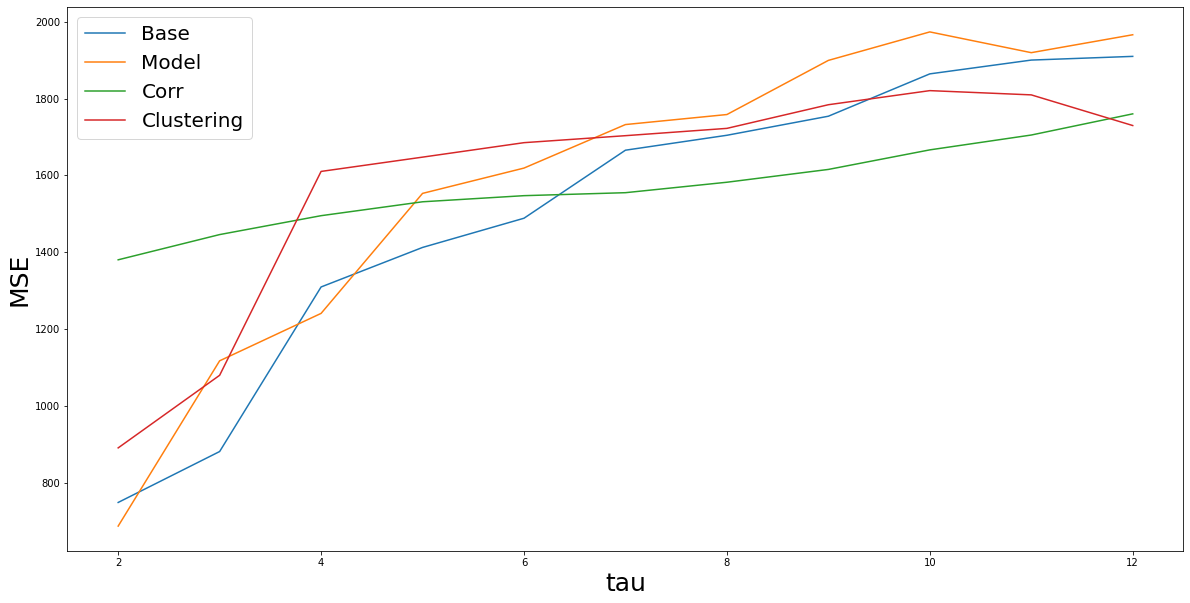

In [11]:
tau = np.arange(2,13)
plt.plot(tau, base, label = "Base")
plt.plot(tau, model, label = "Model")
#plt.plot(tau, model_V, label = "Model_V")
plt.plot(tau, corr, label = "Corr")
plt.plot(tau, clus, label = "Clustering")
#plt.plot(tau, base_clus, label = "Base Model")
plt.xlabel("tau",fontsize = 25)
plt.ylabel("MSE", fontsize = 25)
plt.legend(fontsize = 20)

In [3]:
base_model_corr = []
correlation_model = []
correlation_model_90 = []
model_clustering = []
causality_model = []
model_V = []

In [36]:
for tau in range(4,13):
    base_model_corr.append(np.mean(np.load("base_V_{}.npy".format(tau))))
    correlation_model.append(np.mean(np.load("model_V_corr_{}.npy".format(tau))))
    correlation_model_90.append(np.mean(np.load("model_V_corr_90_{}.npy".format(tau))))
    model_clustering.append(np.mean(np.load("model_clustering_{}.npy".format(tau))))
    causality_model.append(np.mean(np.load("model_V_{}.npy".format(tau))))
    model_V.append(np.mean(np.load("model_V_{}.npy".format(tau))))

In [37]:
tau = np.arange(4,13)

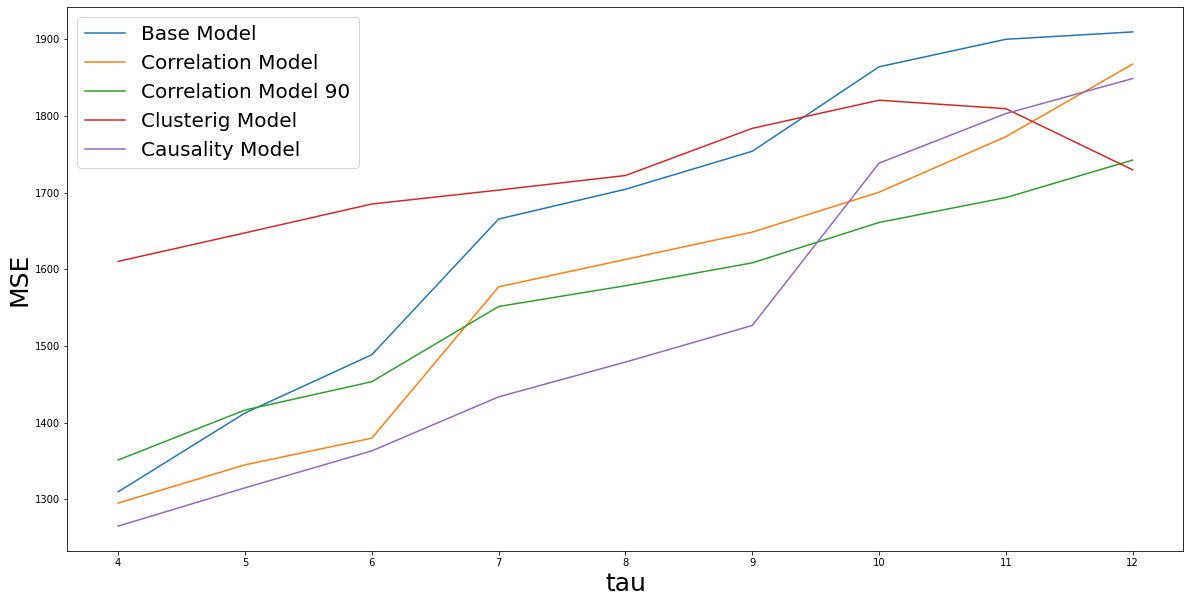

In [38]:
plt.plot(tau, base_model_corr, label = "Base Model")
plt.plot(tau, correlation_model, label = "Correlation Model")
plt.plot(tau, correlation_model_90, label = "Correlation Model 90")
plt.plot(tau, model_clustering, label = "Clusterig Model")
plt.plot(tau, causality_model, label = "Causality Model")
plt.xlabel("tau",fontsize = 25)
plt.ylabel("MSE", fontsize = 25)
plt.legend(fontsize = 20)

In [37]:
    start = np.abs(best_link[:,1].min() - tau)

In [38]:
for tau in range(1,13):
    base_model.append(np.mean(np.load("base_V_{}.npy".format(tau))))
    causality_model.append(np.mean(np.load("model_V_{}.npy".format(tau))))
    correlation_model.append(np.mean(np.load("model_V_corr_{}.npy".format(tau))))
    correlation_model_90.append(np.mean(np.load("model_V_corr_90_{}.npy".format(tau))))

In [39]:
tau = np.arange(1,13)

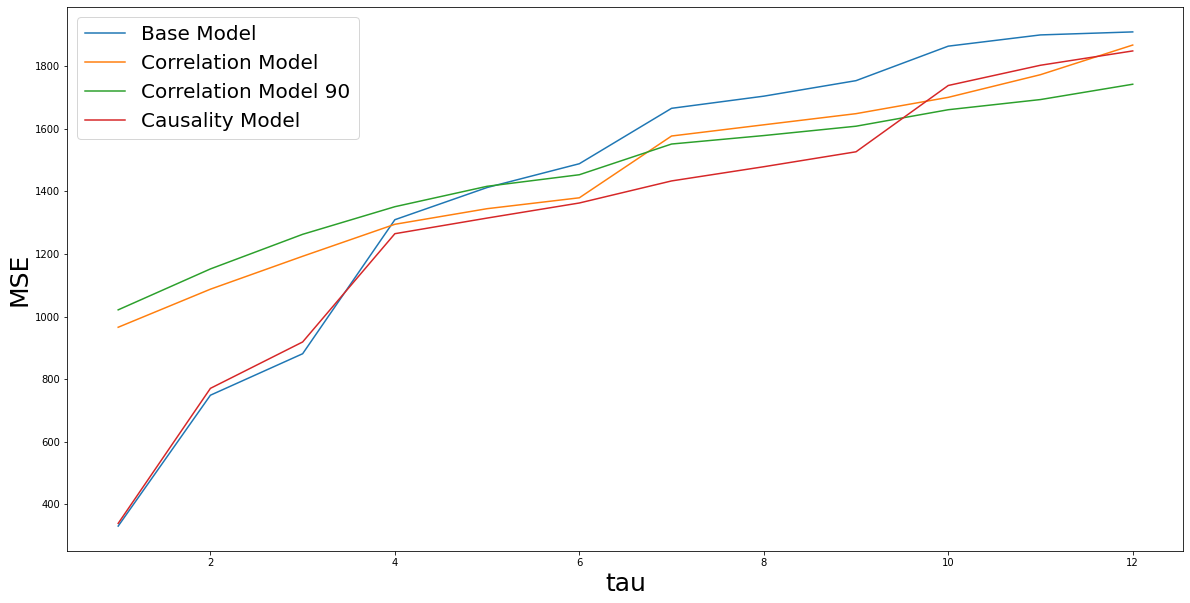

In [41]:
plt.plot(tau, base_model, label = "Base Model")
plt.plot(tau, correlation_model, label = "Correlation Model")
plt.plot(tau, correlation_model_90, label = "Correlation Model 90")
plt.plot(tau, causality_model, label = "Causality Model")
plt.xlabel("tau",fontsize = 25)
plt.ylabel("MSE", fontsize = 25)
plt.legend(fontsize = 20)

In [43]:
base_model= []
causality_model = []

In [44]:
for tau in range(10,13):
    base_model.append(np.mean(np.load("base_VV_{}.npy".format(tau))))
    causality_model.append(np.nanmean(np.load("model_VV_{}.npy".format(tau))))

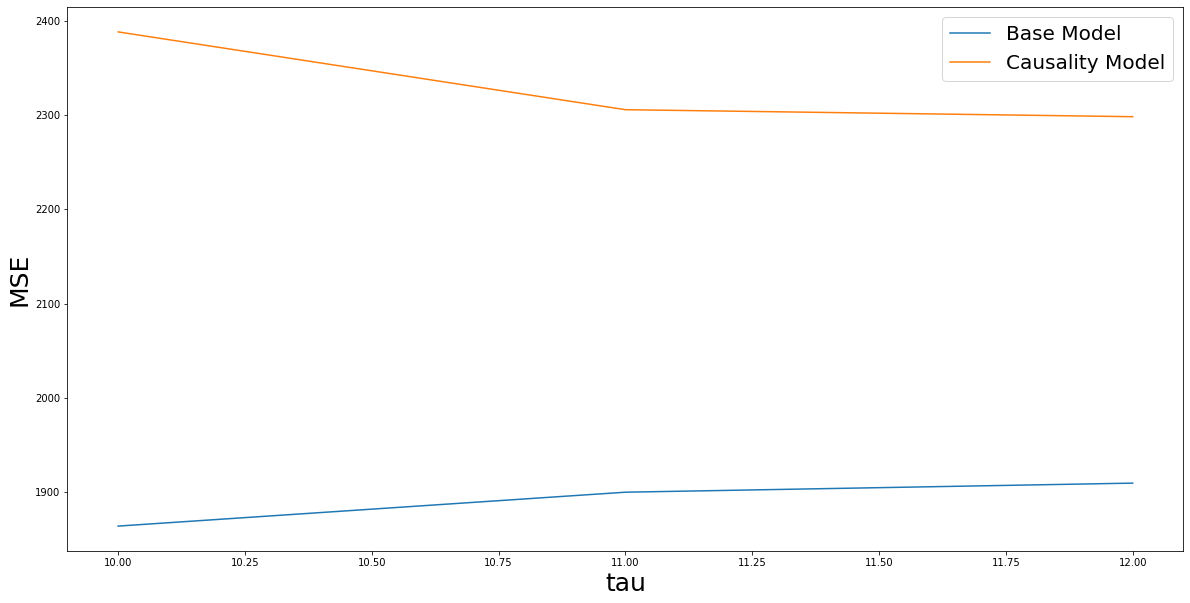

In [46]:
tau = np.arange(10,13)

plt.plot(tau, base_model, label = "Base Model")
plt.plot(tau, causality_model, label = "Causality Model")
plt.xlabel("tau",fontsize = 25)
plt.ylabel("MSE", fontsize = 25)
plt.legend(fontsize = 20)

In [56]:
from statsmodels.tsa.stattools import adfuller

In [92]:
adfuller(ts[:,5])

(-4.925254622084145,
 3.113458964775021e-05,
 7,
 75,
 {'1%': -3.520713130074074,
  '10%': -2.5877813777777776,
  '5%': -2.9009249540740742},
 -224.2622979297197)

In [78]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return(np.array(diff))

In [85]:
ts = difference(ts)

In [86]:
len(ts)

83

In [14]:
model = np.load("model_V_9.npy")

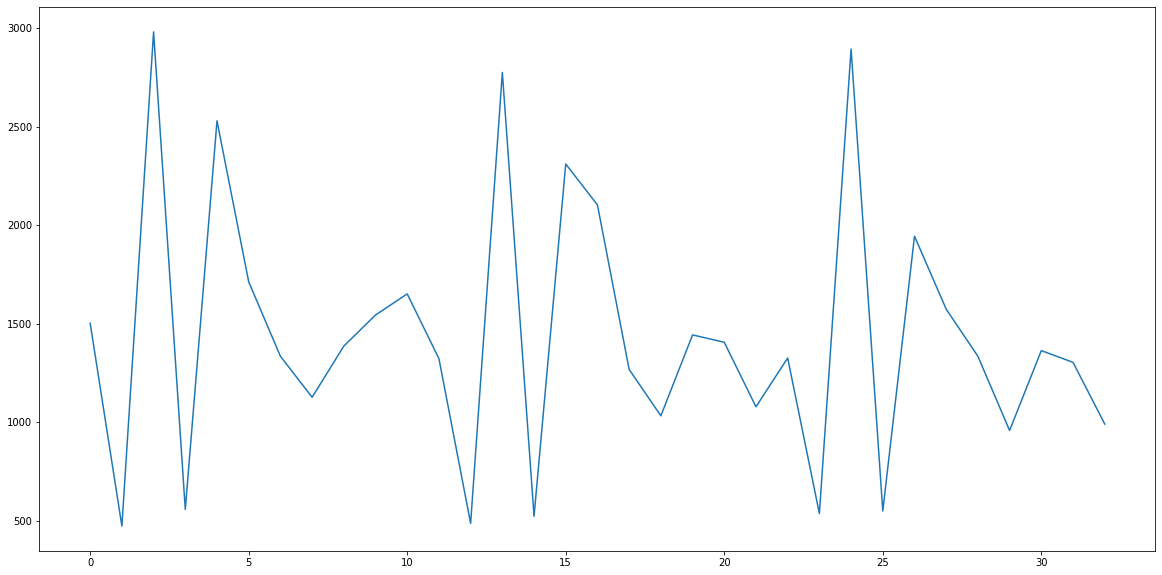

In [5]:
plt.plot(model)

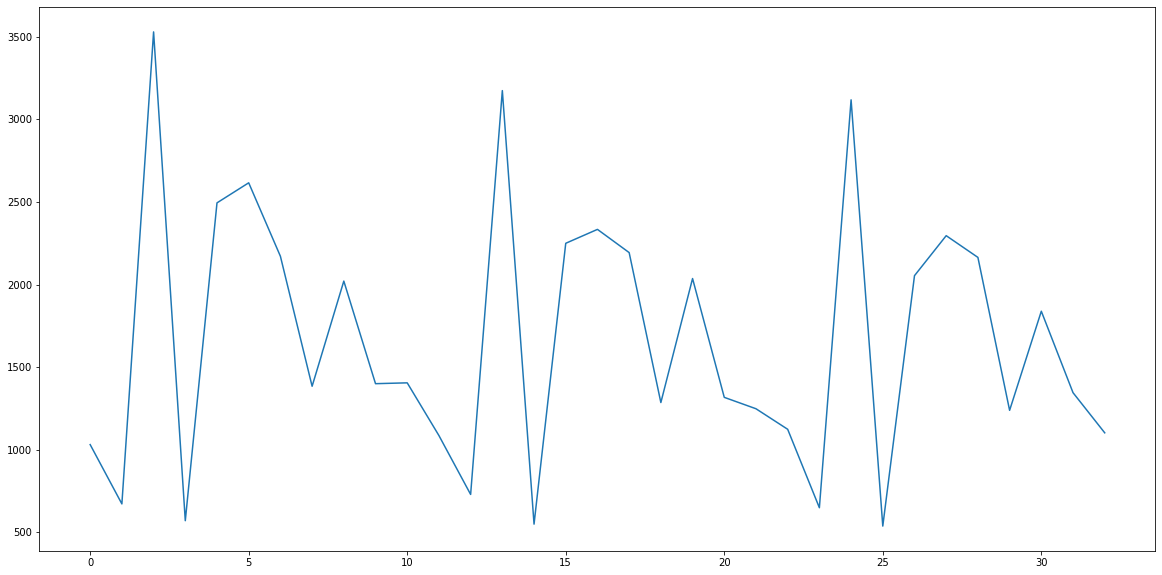

In [6]:
plt.plot(base)

In [7]:
np.mean(model)

1433.5991266705407

In [15]:
np.mean(model)

1526.7563983577393

In [16]:
np.mean(base)

1754.0755061377909

In [8]:
model

array([332.34306654, 203.94413025, 869.63165527, 200.52447653,
       505.78890287, 531.14253205, 330.83157841, 279.88266534,
       435.95890163, 257.05872554,  89.05447799])

In [9]:
base

array([296.5506164 , 211.6885139 , 642.72540232, 189.18883903,
       564.28037248, 382.24020999, 356.54233039, 267.72248051,
       335.27399366, 224.86971485, 120.4701509 ])

In [27]:
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0)}
count = ff.drought_timeseries("ET_gamma_18912015.npy",1977,2015)
ts, V, df_sst = ff.PCA_computer('../../../nc/sst.mnmean.nc', "sst",temporal_limits, 76, -9.96921e+36)

In [28]:
data_sst = ff.data_generator('../../../nc/sst.mnmean.nc', "sst",temporal_limits, -9.96921e+36)

In [30]:
pc = 1
df_sst["pc"] = V[:,pc]
level = 95

In [32]:
sst = ff.time_series_maker(pc, df_sst, data_sst)

In [36]:
df = pd.DataFrame({"drought":count,"sst":sst})

df.sst = df.sst.shift(12)

df = df.dropna()

df.to_csv("droughtSSTAvg.csv")

In [12]:
np.arange(-12,0,1)

array([-12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1])